# What drives the price of a car?

![](../images/kurt.jpeg)

In [1993]:
import scaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

In [1994]:
import warnings
warnings.filterwarnings("ignore")

In [1995]:
pd.set_option('display.max_colwidth', None)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

#### Determine Business

For this modeling exercise, the Title **“What Drives the Price of a Car”** provides the business understanding for the modeling objectives and requirements.

For the used car dealership, their sales people and the consumers, attributes/features of the car help the stakeholders in the following way:
- Car Dealership - What particular cars (i.e., make, model, paint color etc.) are selling that we should stock, is there a region factor if the dealership is national
- Car Sales - Helps with negotiations with customers, what deals to offer to customers, what the Best and Final offer should be, which cars are the hottest selling ones

From a Success Criteria, Identifying the top three features driving the Price of a Car would allow the Dealership and Car Salesman to work on stocking more of these cars but also developing a Pricing/Discounting Structure that maximizes the revenue of the dealership.

#### Assess Situation

We have been supplied with a Vehicles data sets with 426K cars to ensure speed of processing. The main risk is that we may have to remove outliers and missing values which will reduce the number of records available that we will need to split for training and testing the model.

#### Data Mining Goals

As we are using regression modeling for this exercise, the reduction on records would hopefully provide a datasets where there is a linear relationship between the independent and dependent variables.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1996]:
# Describing the data that has been provided using Pandas functions
# Save to df
data=pd.read_csv('../data/vehicles.csv')

# Shape and preview
print('Vehicles DataFrame Shape :',data.shape)
pd.set_option('display.max_columns', None)
data.head()

Vehicles DataFrame Shape : (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [1997]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [1998]:
# Use Dataframe describe/view some basic statistical details like percentile, mean, std etc. of the dataset
data.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [1999]:
#Handle Missing Data
#Calculate the percentage of missing values per column
missing_data = data.isnull().sum() / len(data) * 100
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_data


# Print results
print("Feature        | Value      | Percentage (%)")
print("---------------------------------------------")
for feature, value in missing_data.items():
    print(f"{feature:14} | {value:10.6f} | {value:10.02f}%")


Feature        | Value      | Percentage (%)
---------------------------------------------
size           |  71.767476 |      71.77%
cylinders      |  41.622470 |      41.62%
condition      |  40.785232 |      40.79%
VIN            |  37.725356 |      37.73%
drive          |  30.586347 |      30.59%
paint_color    |  30.501078 |      30.50%
type           |  21.752717 |      21.75%
manufacturer   |   4.133714 |       4.13%
title_status   |   1.930753 |       1.93%
model          |   1.236179 |       1.24%
odometer       |   1.030735 |       1.03%
fuel           |   0.705819 |       0.71%
transmission   |   0.598763 |       0.60%
year           |   0.282281 |       0.28%


## Highly missing columns (>30% missing values):
size           |  71.767476 |      71.77%
cylinders      |  41.622470 |      41.62%
condition      |  40.785232 |      40.79%
VIN            |  37.725356 |      37.73%
drive          |  30.586347 |      30.59%
paint_color    |  30.501078 |      30.50%

## moderate missing values
type           |  21.752717 |      21.75%

## Low missing columns (<5% missing values):
manufacturer, title_status, model, odometer, fuel, transmission, year

In [2000]:
#Check the number of Null Columns
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [2001]:
# Review the correlation of the dataset with the missing values
data.corr(numeric_only=True)

,id,price,year,odometer
id,1.000000,-0.002779,-0.059040,0.010721
price,-0.002779,1.000000,-0.004925,0.010032
year,-0.059040,-0.004925,1.000000,-0.157215
odometer,0.010721,0.010032,-0.157215,1.000000


In [2002]:
# We could try taking the id column out of the dataset to see if it makes a difference
df = data.drop('id', axis=1)
df.corr(numeric_only=True)

,price,year,odometer
price,1.000000,-0.004925,0.010032
year,-0.004925,1.000000,-0.157215
odometer,0.010032,-0.157215,1.000000


In [2003]:
#Handling Strategy:
#Drop the size column (too much missing data, likely not crucial).
#Fill missing values for categorical columns (cylinders, condition, drive, paint_color, type, manufacturer, title_status) using the mode (most frequent value).
#Fill missing numerical columns (year, odometer) with the median.
#Drop VIN column as it is mostly unique per vehicle and not useful for price prediction.

# Drop columns with excessive missing values
df.drop(columns=['size', 'VIN'], inplace=True)

# Fill missing categorical values with mode (most common value)
categorical_cols = ['cylinders', 'condition', 'drive', 'paint_color', 'type', 'manufacturer', 'title_status']
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values with median
numerical_cols = ['year', 'odometer']
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Verify missing values are handled
df.isnull().sum()

region             0
price              0
year               0
manufacturer       0
model           5277
condition          0
cylinders          0
fuel            3013
odometer           0
title_status       0
transmission    2556
drive              0
type               0
paint_color        0
state              0
dtype: int64

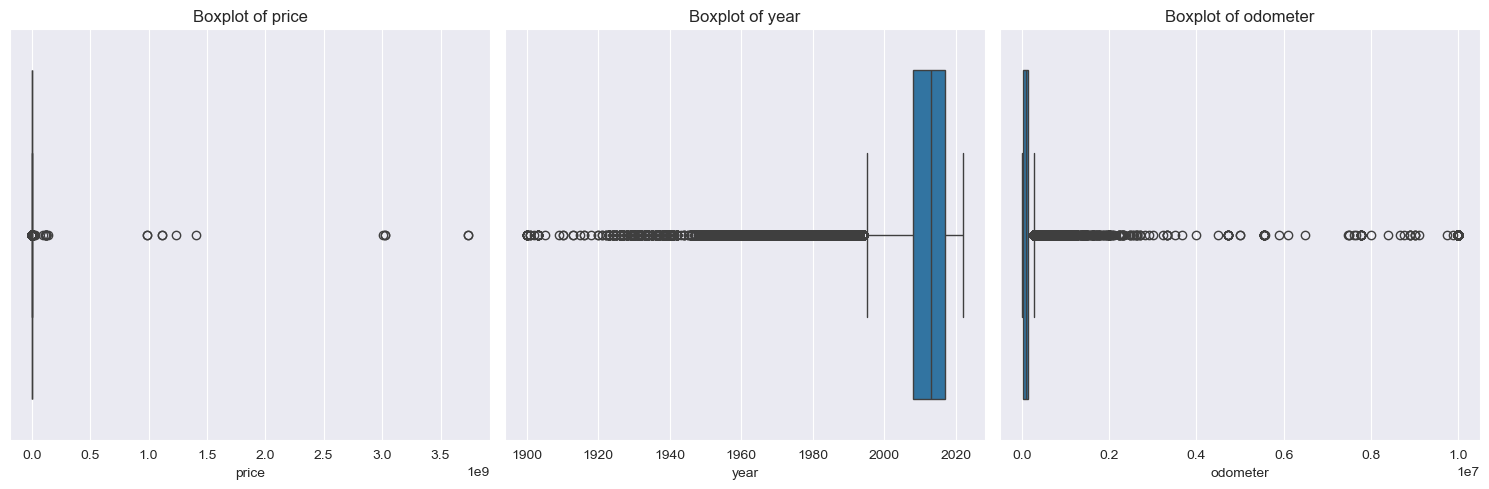

,price,year,odometer
count,4.268800e+05,426880.000000,4.268800e+05
mean,7.519903e+04,2011.240173,9.791454e+04
std,1.218228e+07,9.439234,2.127801e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.813000e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648575e+04,2017.000000,1.330000e+05
max,3.736929e+09,2022.000000,1.000000e+07


In [2004]:
#check for outliers
#To check for outliers, we will analyze key numerical columns:

#Price (main target variable)
#Year (age of the car)
#Odometer (mileage)

# Descriptive statistics for numerical columns
numerical_cols = ['price', 'year', 'odometer']
desc_stats = df[numerical_cols].describe()

# Boxplots for outlier detection
plt.figure(figsize=(15, 5))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

desc_stats

In [2005]:
#Explore Relationships


In [2006]:
#Check the number of Null Columns
df.isnull().sum()

region             0
price              0
year               0
manufacturer       0
model           5277
condition          0
cylinders          0
fuel            3013
odometer           0
title_status       0
transmission    2556
drive              0
type               0
paint_color        0
state              0
dtype: int64

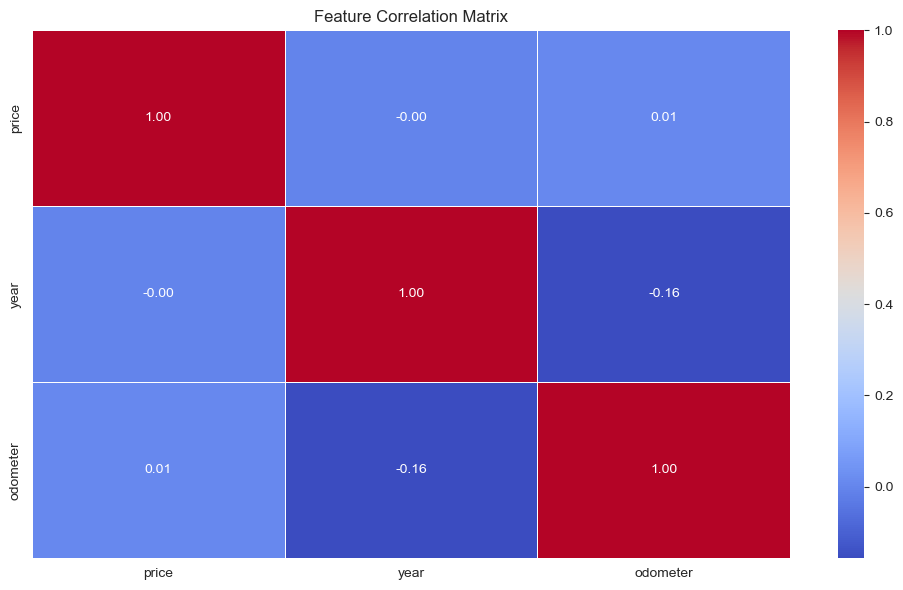

In [2007]:
# Compute correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

In [2008]:
#. Scatter Plots (Price vs. Key Features)
# helps visualize relationship (eg , newer cars might cost more)

## Observation:
This also shows that Prices of 0 and odometer of zero are skewing the visualizations, As these are used cars,
there should be a value for the odometer but you could explain price of 0 as a situation where the vehicle
has not been evaluated and priced for the dataset. For odomoter, this could be an instance of bad data and this
could also be the case for 0 price


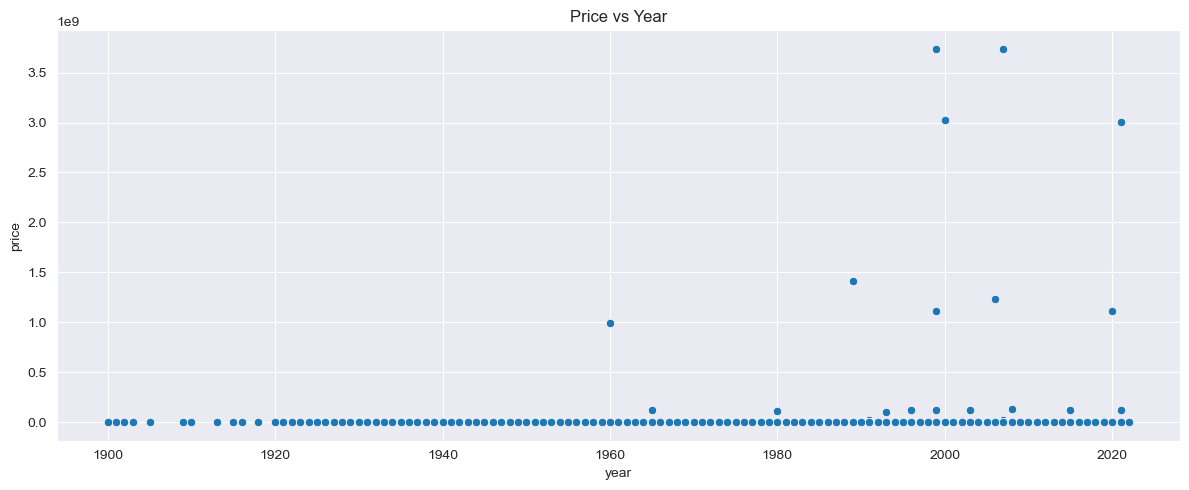

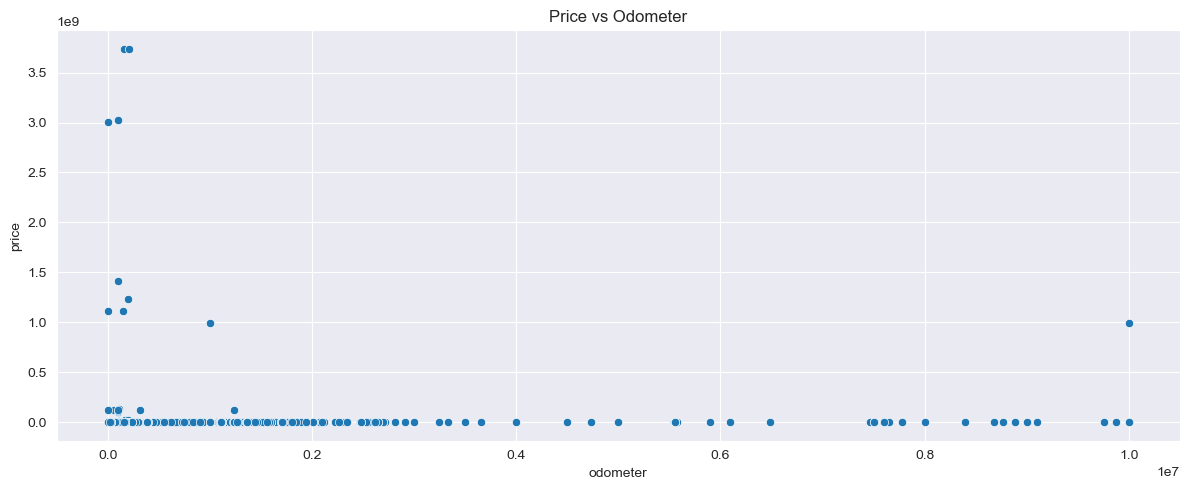

In [2009]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df['year'], y=df['price'])
plt.title("Price vs Year")

plt.figure(figsize=(12, 5))
sns.scatterplot(x=df['odometer'], y=df['price'])
plt.title("Price vs Odometer")
plt.show()

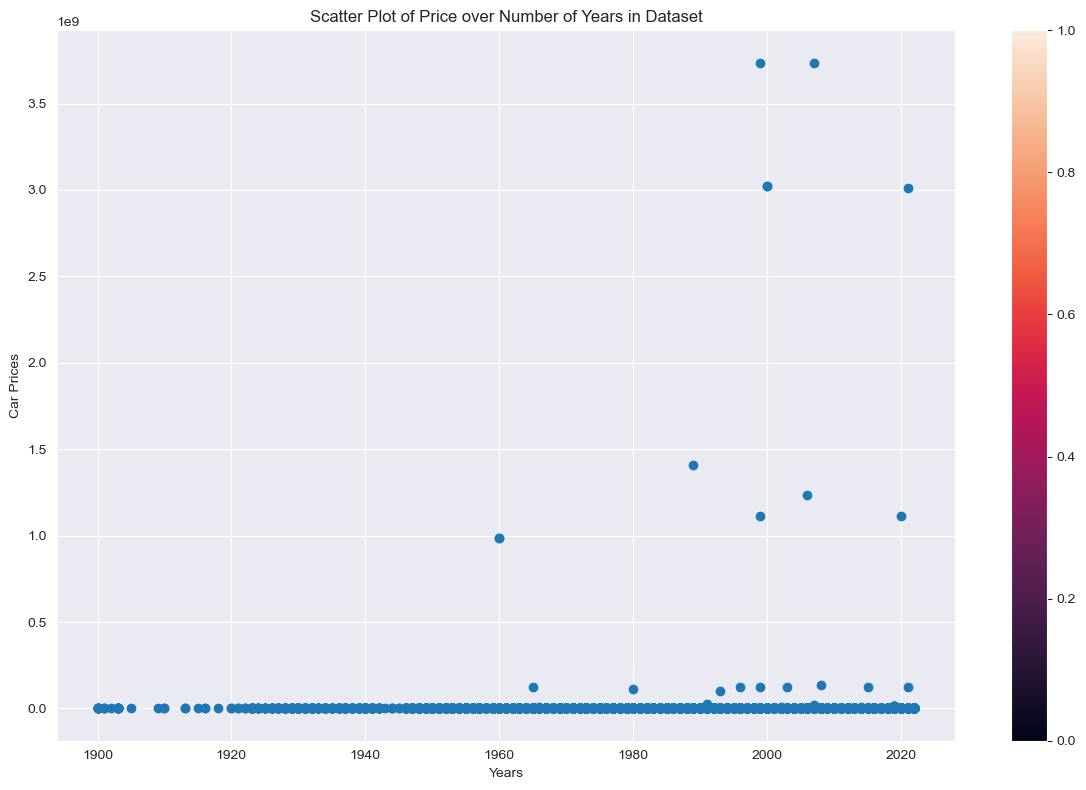

In [2010]:
# Scatter plot of year of manufacture vs car price
plt.figure(figsize=(12,8))
plt.scatter(df['year'], df['price'])

# Adding Title to the Plot
plt.title("Scatter Plot of Price over Number of Years in Dataset")

# Setting the X and Y labels
plt.xlabel('Years')
plt.ylabel('Car Prices')
plt.colorbar()

plt.show()

In [2011]:
# The missing and NaN values in the datasets are skewing the visualizations where looking at the plots doesn't
# make sense or provide any values, for example, the line of 0.0 are due to missing Car Prices (i.e., NaN values) which
# means you can't really see a trend of Car Prices over the number of years.
# As the chart includes 2020, I think we should see a decrease in car prices in early 2020 athen followed by an increase due to supply chain issues

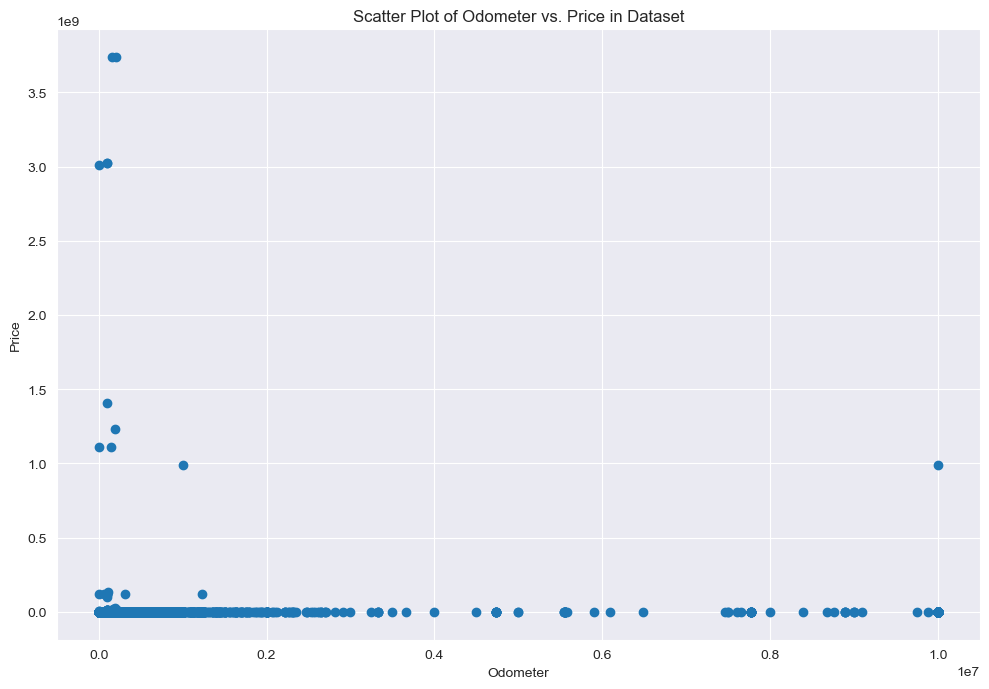

In [2012]:
# Let's try a scatter plot of price vs odomoter to see if there is a Trend, i.e., the lower the odometer, the more
# expensive or higher the car price
#fig, ax = plt.subplots(figsize=(10,7))

#fig, ax = plt.subplots(figsize=(10,7))
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(df['odometer'], df['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()


In [2013]:
# This also shows that Prices of $0 and odometer of zero are skewing the visualizations, As these are used cars,
# there should be a value for the odometer but you could explain price of $0 as a situation where the vehicle
# has not been evaluated and priced for the dataset. For odomoter, this could be an instance of bad data and this
# could also be the case for $0 price

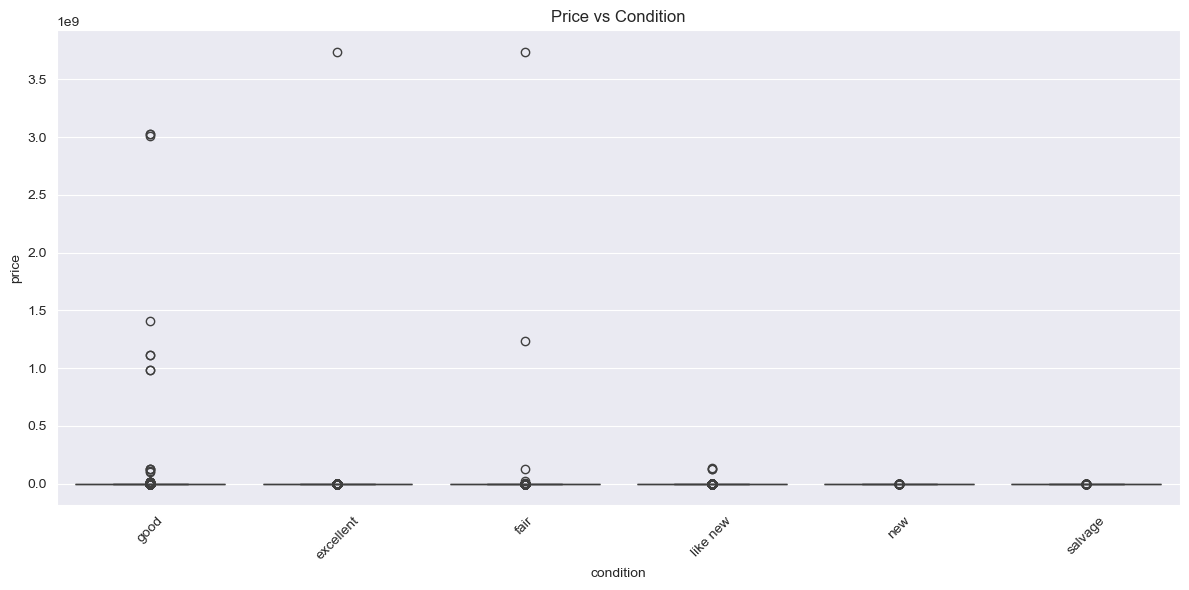

In [2014]:
#Boxplots for Categorical Features
#how manufacturer, condition, or fuel type affects price.
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['condition'], y=df['price'])
plt.xticks(rotation=45)
plt.title("Price vs Condition")
plt.show()

In [2015]:
#df1 = data[(data['price']>0) & (data['odometer']>0)]
df1 = df.query("price > 0").dropna()
df1

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,white,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,6 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,6 cylinders,diesel,4174.0,clean,other,4wd,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy


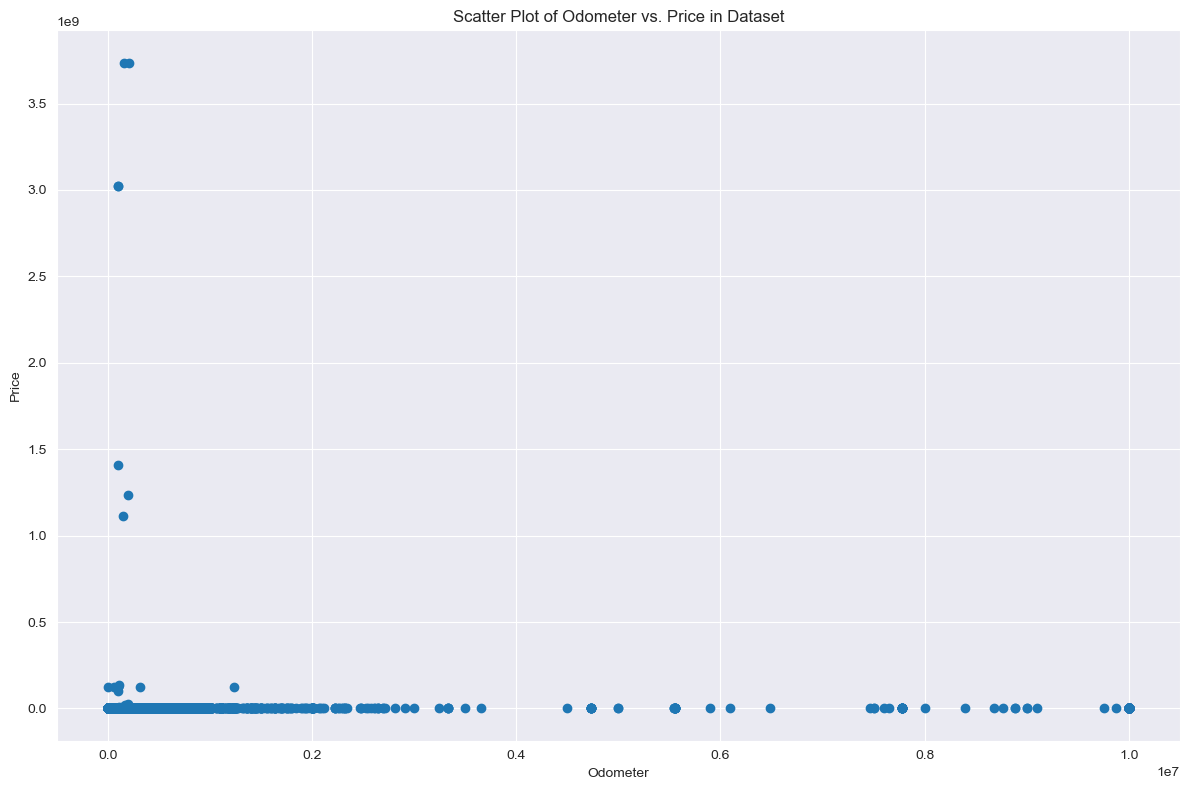

In [2016]:
# Lets look at a scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df1['odometer'], df1['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

In [2017]:
# Dropping null rows reduced the record size to 32k, but the data is still skewed towards very low values.
# See below for the min and max values of odometer and price based on current record selection

In [2018]:
print("Minimum Price of cars in filtered dataset: ", df1['price'].min())
print("Maximum Price of cars in filtered dataset: ", df1['price'].max())
print("Minimum Odometer on cars in filtered dataset: ", df1['odometer'].min())
print("Maximum Odometer on cars in filtered dataset: ", df1['odometer'].max())

Minimum Price of cars in filtered dataset:  1
Maximum Price of cars in filtered dataset:  3736928711
Minimum Odometer on cars in filtered dataset:  0.0
Maximum Odometer on cars in filtered dataset:  10000000.0


In [2019]:
# In the data preparations section, we will use the median, mean and other variables standardization techniques
# to fill in the low and zero missing values

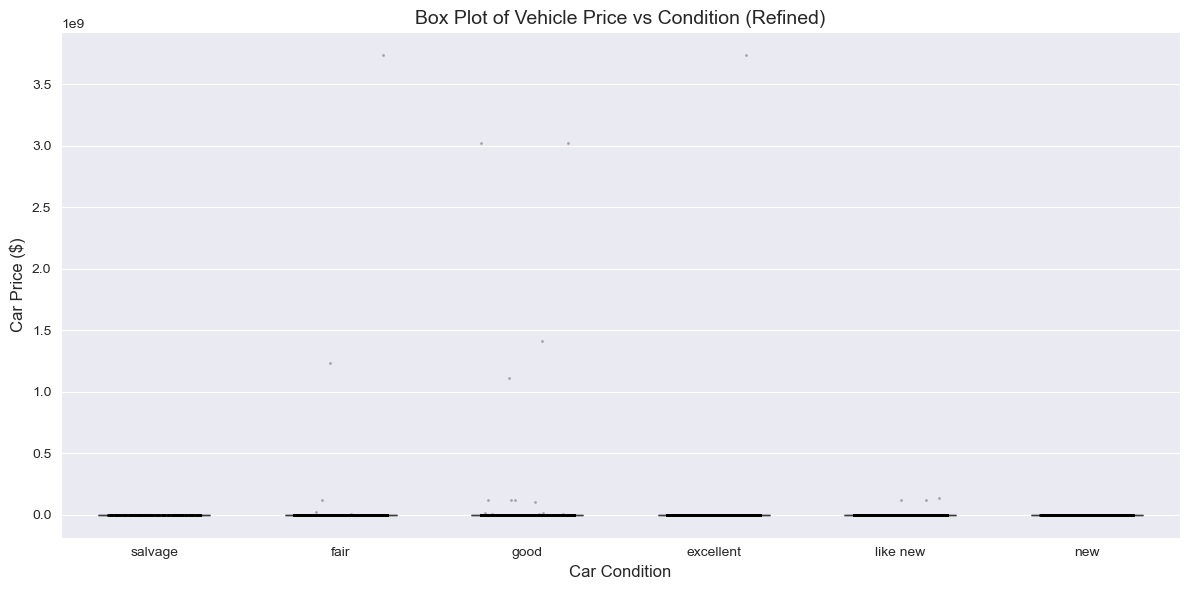

In [2020]:
# Define an ordered list for better sorting
condition_order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']

plt.figure(figsize=(12, 6))

# Create Boxplot (without outliers to keep it clean)
ax = sns.boxplot(x=df1["condition"], y=df1["price"], order=condition_order, showfliers=False, width=0.6)

# Overlay a jittered swarmplot for better visibility
sns.stripplot(x=df1["condition"], y=df1["price"], order=condition_order,
              color="black", alpha=0.3, size=2, jitter=0.25)

# Add labels and title
ax.set_title("Box Plot of Vehicle Price vs Condition (Refined)", fontsize=14)
ax.set_xlabel("Car Condition", fontsize=12)
ax.set_ylabel("Car Price ($)", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [2021]:
#Boxplot + Stripplot → Due to large dataset the data is cluttered with too many points , so lets avoid clutter using violinplot

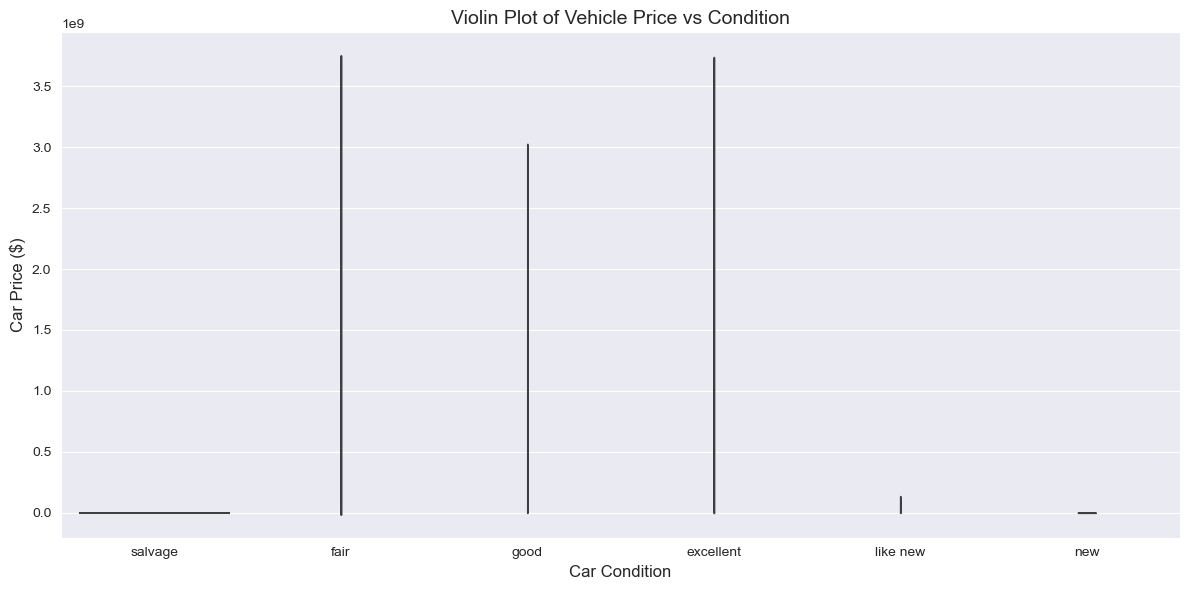

In [2022]:
plt.figure(figsize=(12, 6))

# Violin plot shows distribution + density
sns.violinplot(x=df1["condition"], y=df1["price"], order=condition_order, inner="quartile")

# Add title and labels
plt.title("Violin Plot of Vehicle Price vs Condition", fontsize=14)
plt.xlabel("Car Condition", fontsize=12)
plt.ylabel("Car Price ($)", fontsize=12)

plt.show()

In [2023]:
#Newer condition cars (like new, new) have higher median prices.
#Higher price variability in excellent and like new cars.
#salvage cars have the lowest median price.

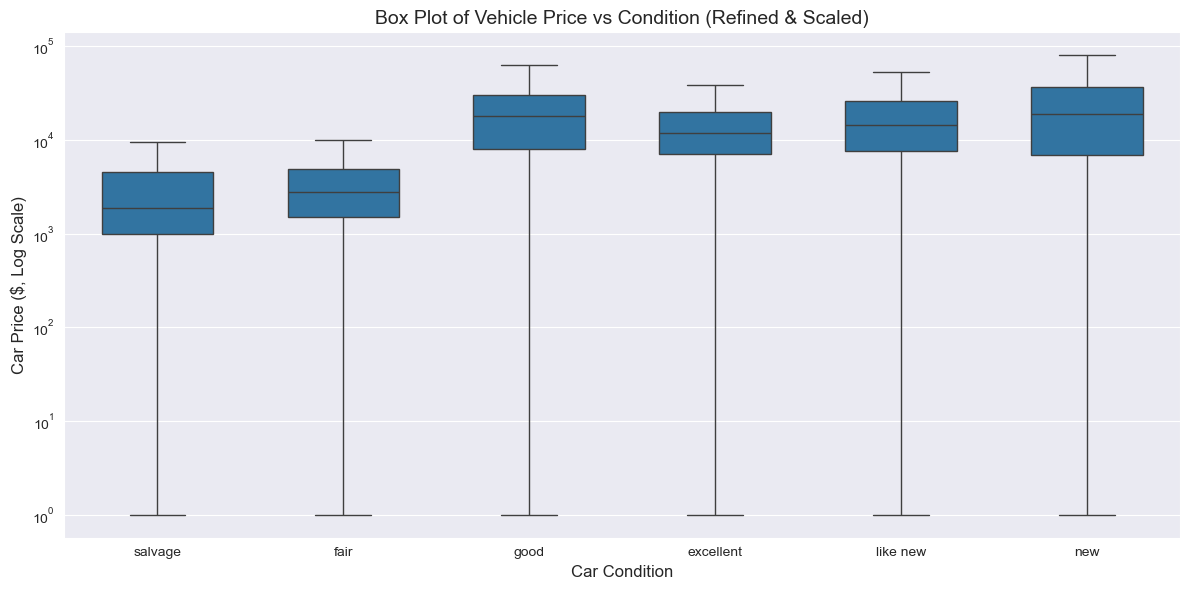

In [2024]:
# Define an ordered list for sorting
condition_order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']

# Apply a price cap to remove extreme outliers (e.g., max $80,000)
df_filtered = df1[df1["price"] < 80000]

plt.figure(figsize=(12, 6))

# Boxplot without extreme outliers
ax = sns.boxplot(x=df_filtered["condition"], y=df_filtered["price"],
                 order=condition_order, showfliers=False, width=0.6)

# Log-scale the price axis to reduce skew (Optional)
ax.set_yscale("log")

# Title and Labels
ax.set_title("Box Plot of Vehicle Price vs Condition (Refined & Scaled)", fontsize=14)
ax.set_xlabel("Car Condition", fontsize=12)
ax.set_ylabel("Car Price ($, Log Scale)", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

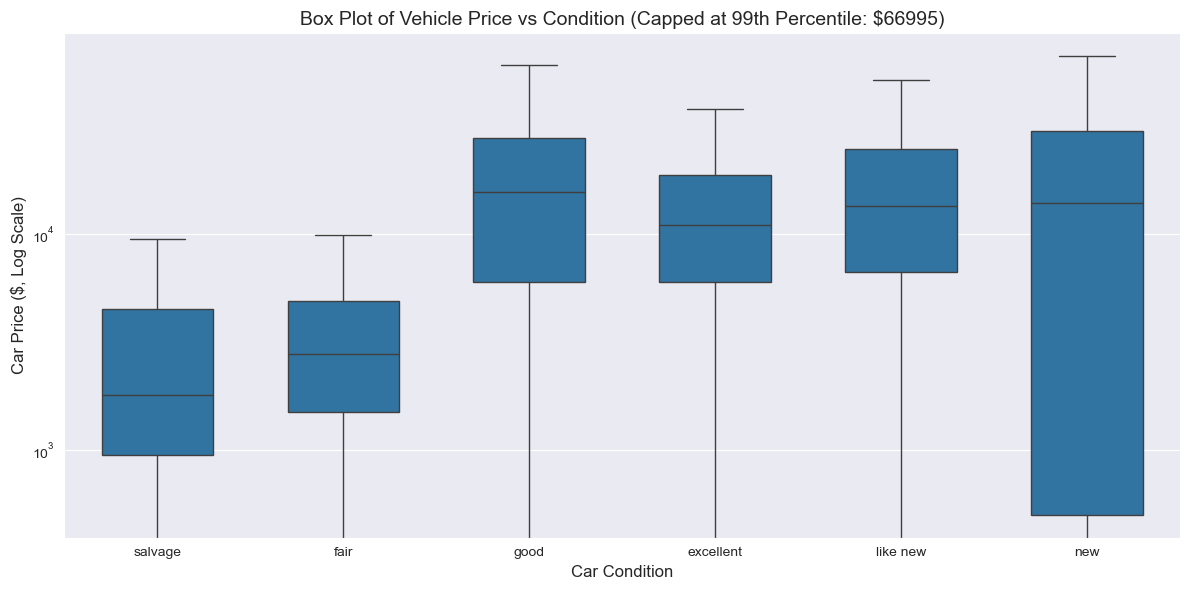

In [2025]:
#Clearer Visualization
#1.Set an optimal price cap
#2.Use log scale on price
#3.Compare Boxplot & Violin plot

# Define an ordered list for sorting conditions
condition_order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']

# Dynamically determine price cap (99th percentile)
price_cap = np.percentile(df["price"], 99)  # Set cap at the 99th percentile
df_filtered = df[df["price"] < price_cap]  # Remove extreme outliers

plt.figure(figsize=(12, 6))

# Boxplot (without extreme outliers)
ax = sns.boxplot(x=df_filtered["condition"], y=df_filtered["price"],
                 order=condition_order, showfliers=False, width=0.6)

# Apply log scale for better visibility
ax.set_yscale("log")

# Titles & labels
ax.set_title(f"Box Plot of Vehicle Price vs Condition (Capped at 99th Percentile: ${int(price_cap)})", fontsize=14)
ax.set_xlabel("Car Condition", fontsize=12)
ax.set_ylabel("Car Price ($, Log Scale)", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [2026]:
#clean, structured, and ready for machine learning

In [2027]:
df1

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,white,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,6 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,6 cylinders,diesel,4174.0,clean,other,4wd,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy


In [2028]:
df_copy = df1.copy().dropna()
df_copy.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al
28,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al
30,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al


In [2029]:
#Let's print the number of records
df_copy.shape

(385279, 15)

In [2030]:
# Reviewing the records, we can state that id and VIN are not useful for predicting the car price
# Attributes region and state are also duplicates. We can remove one for now.
# Removing region as the unique count shows some region with 1 car

In [2031]:
# Drop the following columns

df_copy.drop('region', axis=1, inplace=True)
df_copy


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,white,wy
426876,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,6 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,34990,2020.0,cadillac,xt4 sport suv 4d,good,6 cylinders,diesel,4174.0,clean,other,4wd,hatchback,white,wy
426878,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy


In [2032]:
#Handling Missing Values in a structured Manner:
missing_values = df_copy.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [2033]:
# Fill missing numerical values with median
df_copy.fillna(df_copy.median(numeric_only=True), inplace=True)

# Fill missing categorical values with mode
df_copy.fillna(df_copy.mode().iloc[0], inplace=True)

In [2034]:
print(df_copy.columns)

Index(['price', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'state'],
      dtype='object')


In [2035]:
#Feature Engineering
#Creating ‘Car Age’ from Year
current_year = datetime.now().year
df_copy["car_age"] = current_year - df_copy["year"]

In [2036]:
df_copy["car_age"]

27        11.0
28        15.0
29         5.0
30         8.0
31        12.0
          ... 
426875     6.0
426876     5.0
426877     5.0
426878     7.0
426879     6.0
Name: car_age, Length: 385279, dtype: float64

In [2037]:
#Handle Edge Cases, if year has missing values

df_copy["year"].fillna(df_copy["year"].median(), inplace=True)
df_copy["car_age"] = current_year - df_copy["year"]

In [2038]:
df_copy["year"] = pd.to_numeric(df_copy["year"], errors="coerce")

In [2039]:
df_copy[["year", "car_age"]].head()

,year,car_age
27,2014.0,11.0
28,2010.0,15.0
29,2020.0,5.0
30,2017.0,8.0
31,2013.0,12.0


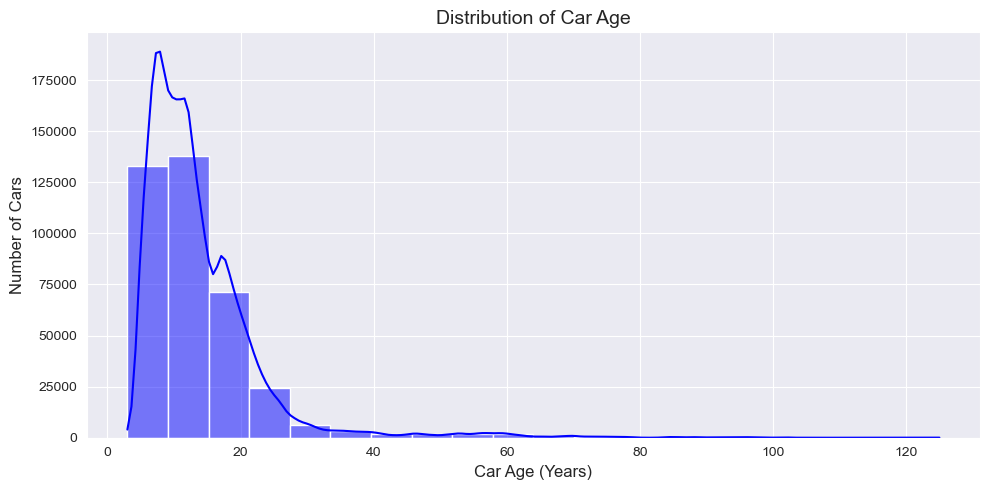

In [2040]:
#visualization of car age Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_copy["car_age"], bins=20, kde=True, color="blue")

# Labels and Title
plt.xlabel("Car Age (Years)", fontsize=12)
plt.ylabel("Number of Cars", fontsize=12)
plt.title("Distribution of Car Age", fontsize=14)

plt.show()

In [2041]:
#Check on which columns are nulls
df_copy.isnull().sum()

price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
car_age         0
dtype: int64

In [2042]:
#lets check column with zero values
s = df_copy.eq(0).any()
s

price           False
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer         True
title_status    False
transmission    False
drive           False
type            False
paint_color     False
state           False
car_age         False
dtype: bool

In [2043]:
#only odometer are the values with zero values

In [2044]:
# Get the count of Zeros in column 'Odometer'
count = (df_copy['odometer'] == 0).sum()
print('Count of zeros in odometer : ', count)

Count of zeros in odometer :  1060


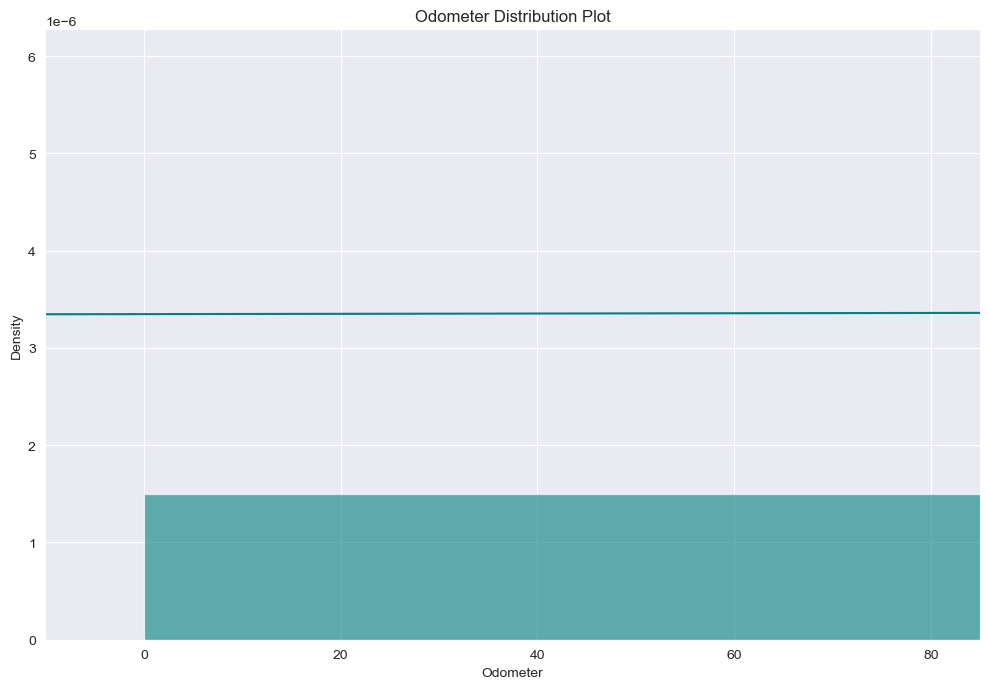

In [2045]:
# Let's look at the data in Odometer Column and see the distribution of the values
fig, ax = plt.subplots(figsize=(10,7))
ax = df_copy["odometer"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
df_copy["odometer"].plot(kind='density', color='teal')
ax.set_title('Odometer Distribution Plot')
ax.set(xlabel='Odometer')
plt.xlim(-10,85)
plt.show()

In [2046]:
# mean Odometer
print('The mean of "Odometer" is %.2f' %(df_copy["odometer"].mean(skipna=True)))
# median Odometer
print('The median of "Odometer" is %.2f' %(df_copy["odometer"].median(skipna=True)))

The mean of "Odometer" is 98108.78
The median of "Odometer" is 86337.00


In [2047]:
#Count of zeros in odometer :  1060
df_copy.drop(df_copy[df_copy['odometer'] == 0].index, inplace = True)
df_copy

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_age
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al,11.0
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al,15.0
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al,5.0
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al,8.0
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,white,wy,6.0
426876,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,6 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy,5.0
426877,34990,2020.0,cadillac,xt4 sport suv 4d,good,6 cylinders,diesel,4174.0,clean,other,4wd,hatchback,white,wy,5.0
426878,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,7.0


In [2048]:
# Quick check to ensure all rows do not include any zero values
s = df_copy.eq(0).any()
s

price           False
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer        False
title_status    False
transmission    False
drive           False
type            False
paint_color     False
state           False
car_age         False
dtype: bool

In [2049]:
df_copy

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,car_age
27,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,pickup,white,al,11.0
28,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,pickup,blue,al,15.0
29,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,pickup,red,al,5.0
30,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,pickup,red,al,8.0
31,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,white,wy,6.0
426876,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,6 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy,5.0
426877,34990,2020.0,cadillac,xt4 sport suv 4d,good,6 cylinders,diesel,4174.0,clean,other,4wd,hatchback,white,wy,5.0
426878,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,7.0


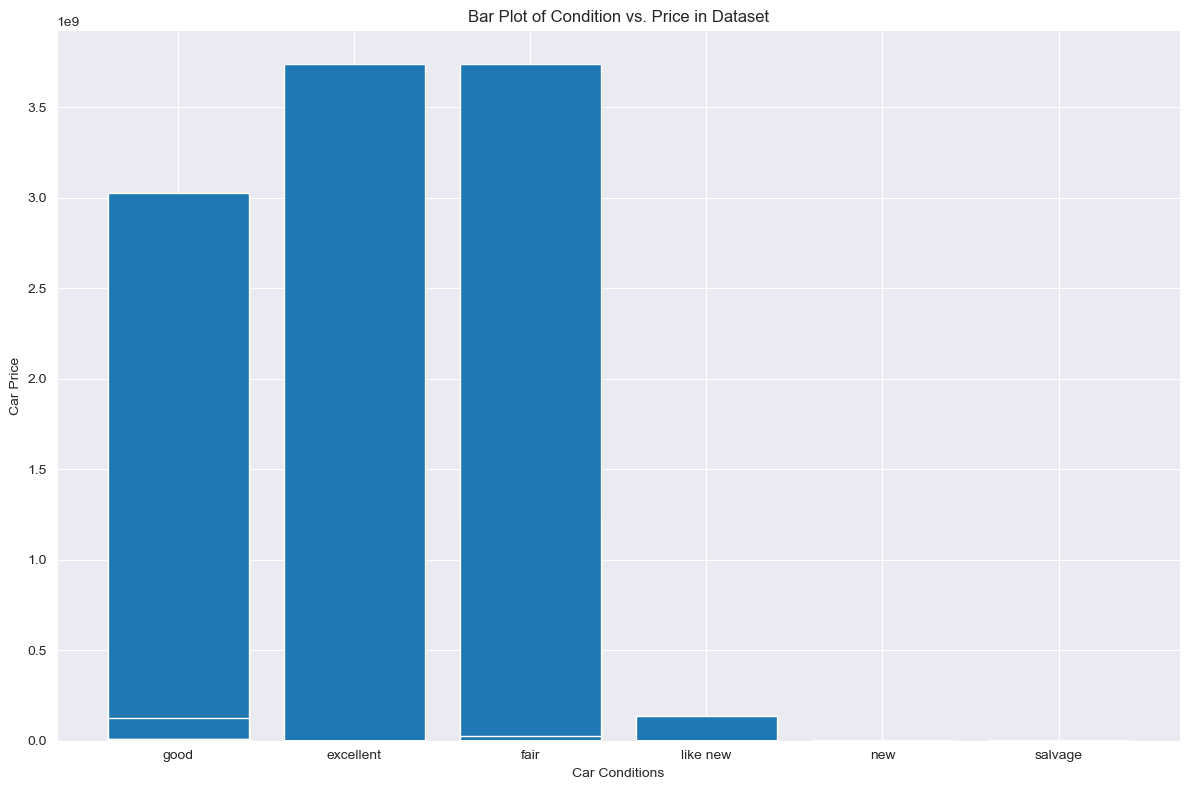

In [2050]:
# Lets look at a scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(df_copy["condition"],df_copy["price"])
# set a title and labels
ax.set_title('Bar Plot of Condition vs. Price in Dataset')
ax.set_xlabel('Car Conditions')
ax.set_ylabel('Car Price')
plt.show()

#plt.bar(df_copy["condition"],df_copy["price"])
#plt.show()

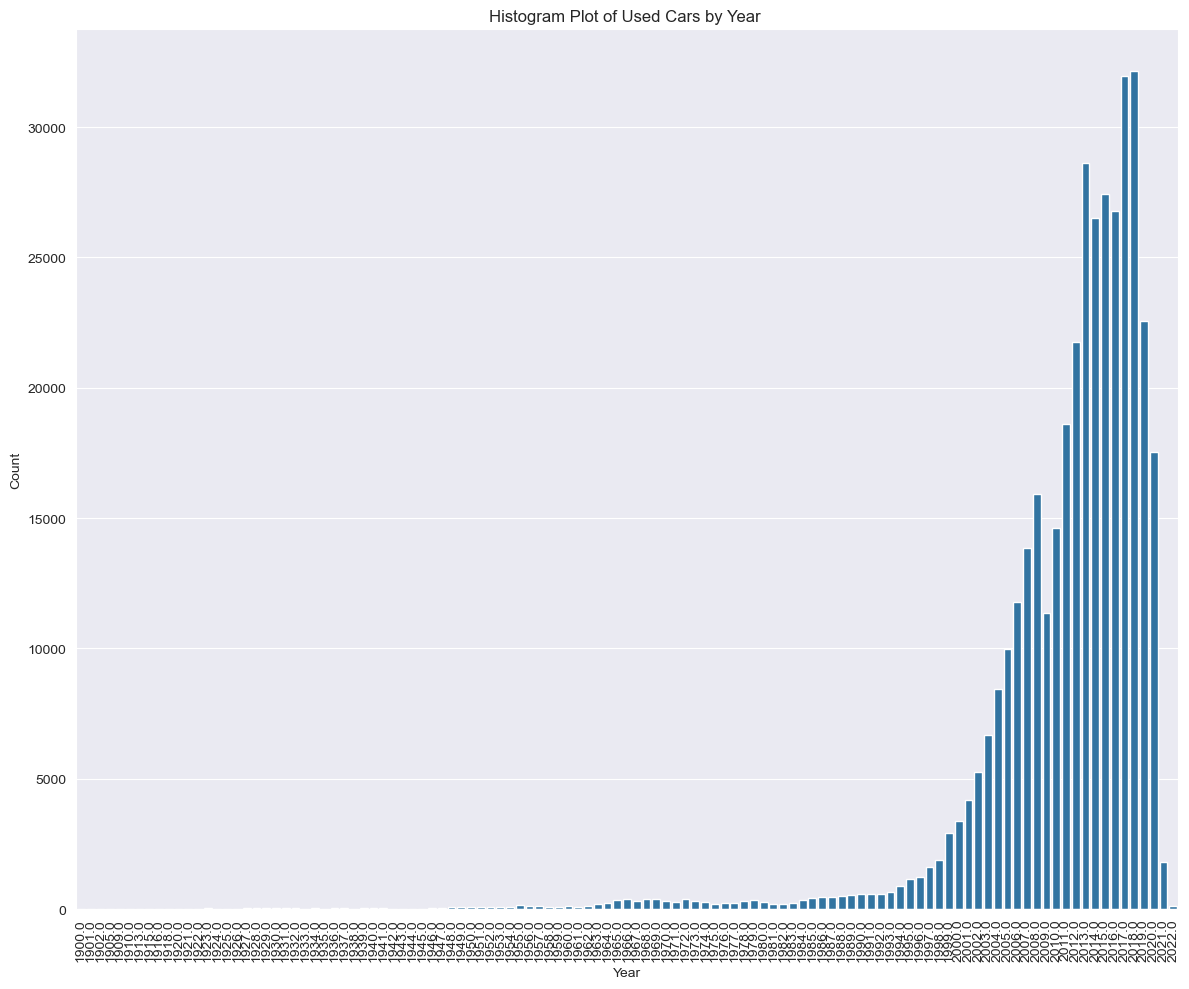

In [2051]:
# Plot the number of used car counts by year

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='year', data=df_copy , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Year ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)


# Setting the X and Y labels
ax.set_xlabel("Year")
ax.set_ylabel("Count")

plt.show()

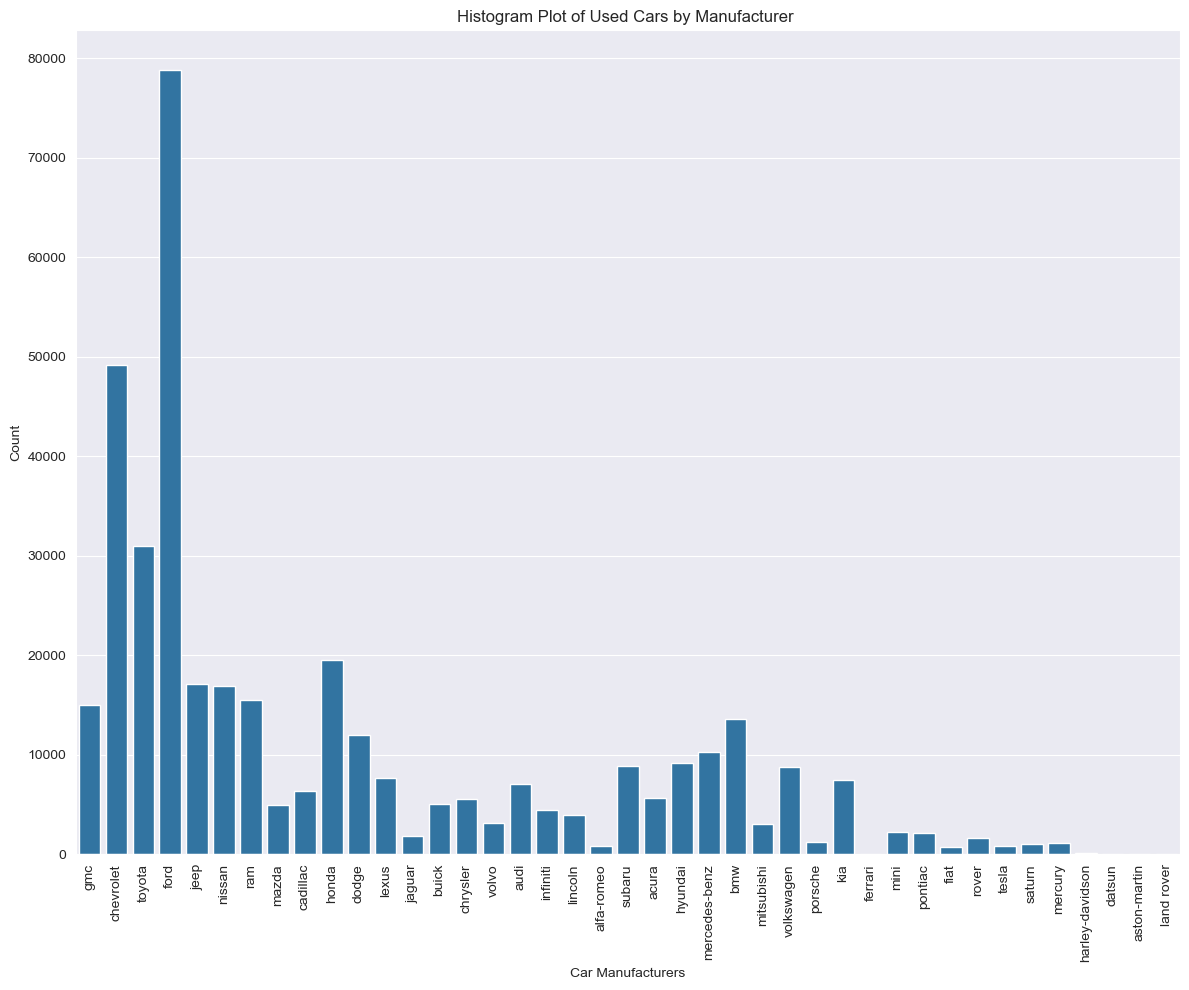

In [2052]:
# Plot the number of used car counts by manufacturer

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='manufacturer', data=df_copy , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Manufacturer ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)


# Setting the X and Y labels
ax.set_xlabel("Car Manufacturers")
ax.set_ylabel("Count")

plt.show()

In [2053]:
# From the chart above, you can see that Ford, Chevrolet and Toyota are the top 3 manufacturers

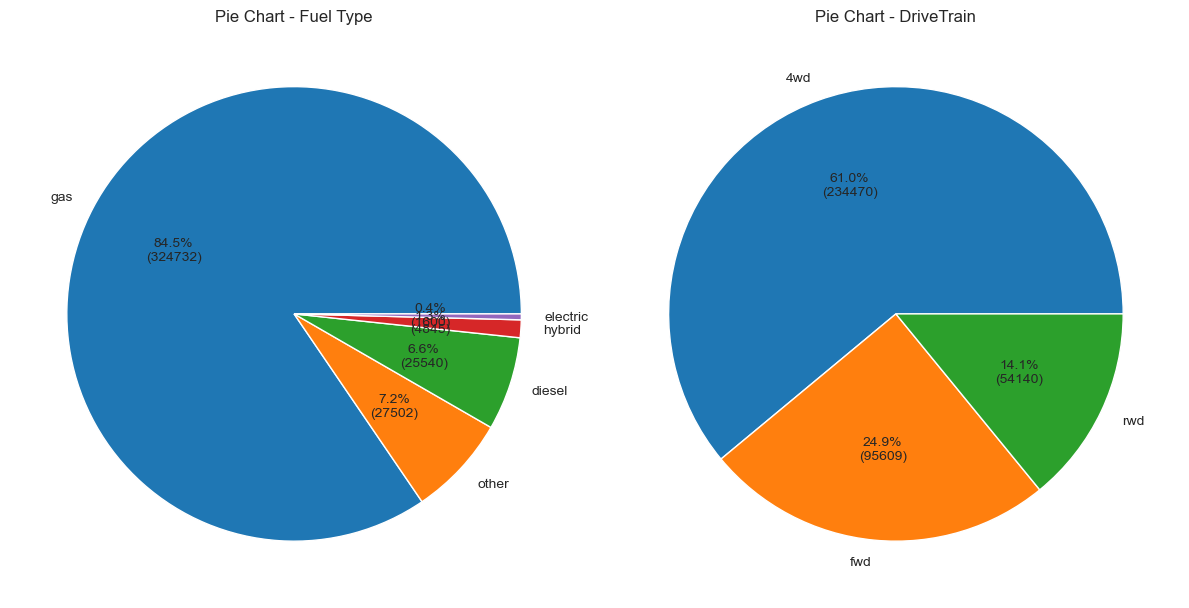

In [2054]:
# Plot some pie charts to visualize the number of used cars based on car features
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))

# plot each pie chart in a separate subplot

ax1.set_title('Pie Chart - Fuel Type')
s = df_copy['fuel'].value_counts()
ax1.pie(s,labels = s.index,  autopct=autopct_format(s))

ax2.set_title('Pie Chart - DriveTrain')
s = df_copy['drive'].value_counts()
ax2.pie(s,labels = s.index, autopct=autopct_format(s))

plt.show()


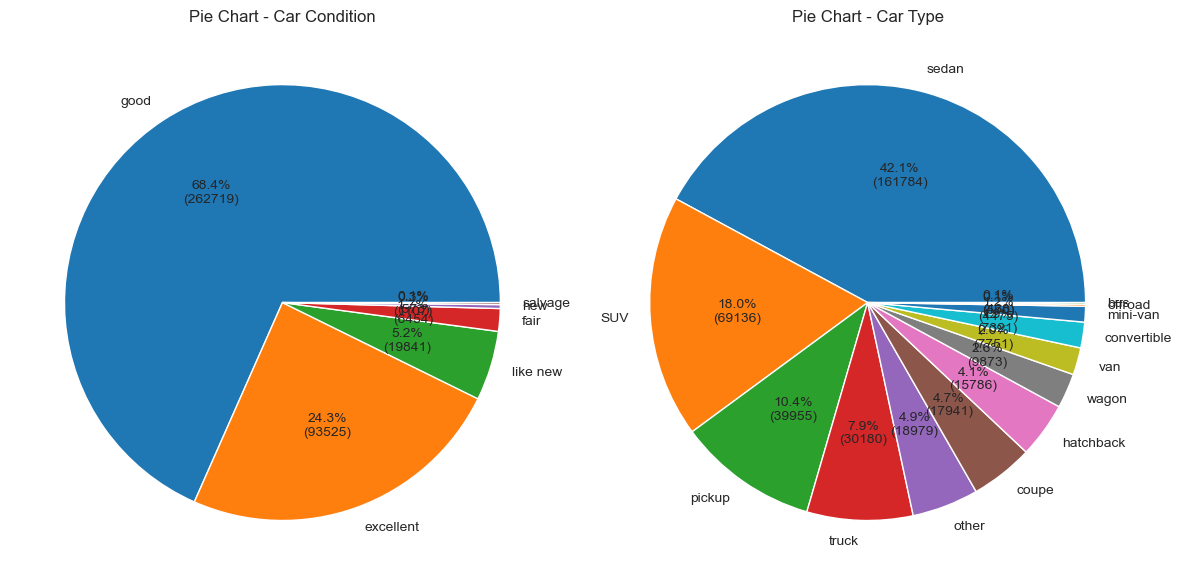

In [2055]:
# create a figure with two subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,7))

# plot each pie chart in a separate subplot

ax1.set_title('Pie Chart - Car Condition')
s = df_copy['condition'].value_counts()
ax1.pie(s,labels = s.index,  autopct=autopct_format(s))

ax2.set_title('Pie Chart - Car Type')
s = df_copy['type'].value_counts()
ax2.pie(s,labels = s.index, autopct=autopct_format(s))


plt.show()

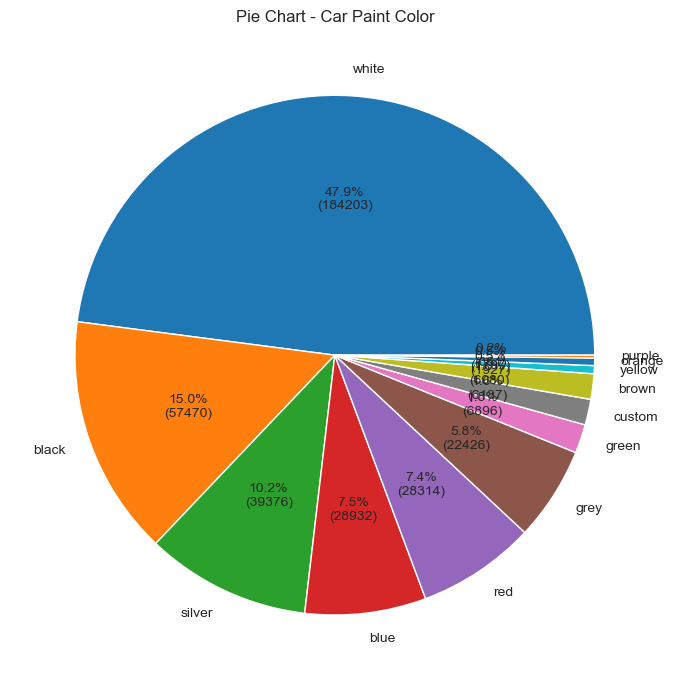

In [2056]:
# create a figure with subplots
#fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,7))

# plot each pie chart in a separate subplot

ax.set_title('Pie Chart - Car Paint Color')
s = df_copy['paint_color'].value_counts()
ax.pie(s,labels = s.index, autopct=autopct_format(s))


plt.show()

In [2057]:
#Lets look at the Correlation after some data manipulation
df_copy.corr(numeric_only=True)

,price,year,odometer,car_age
price,1.000000,-0.004264,0.000967,0.004264
year,-0.004264,1.000000,-0.170350,-1.000000
odometer,0.000967,-0.170350,1.000000,0.170350
car_age,0.004264,-1.000000,0.170350,1.000000


### Observation on correlation matrix

The correlation matrix for various features in your dataset: price, year, odometer, and car_age. Here's a breakdown of the correlations based on the provided values:

Price & Year: Correlation of -0.004264, which suggests there's a very weak, almost negligible inverse relationship between price and year.
Price & Odometer: Correlation of 0.000967, which is essentially no correlation between price and odometer.
Price & Car Age: Correlation of 0.004264, which indicates a very weak positive relationship between price and car age.
Year & Odometer: Correlation of -0.170350, suggesting a slight negative relationship between the year of the car and its mileage (older cars tend to have higher mileage).
Year & Car Age: A perfect negative correlation of -1. This makes sense because car age is derived from the year (car_age = current year - year), so it will always be inversely related.
Odometer & Car Age: Correlation of 0.170350, indicating a slight positive relationship between mileage(odometer) and car age (older cars might have more mileage).


### insight

The data suggests that price does not strongly correlate with the other factors, though there is a tiny positive relationship with odometer and a slight negative relationship with year.
Car age seems to have the weakest correlation with price but is strongly linked to year, as expected.

In [2058]:
#visualize the correlation matrix as a heatmap using Seaborn for a more intuitive view of the relationships

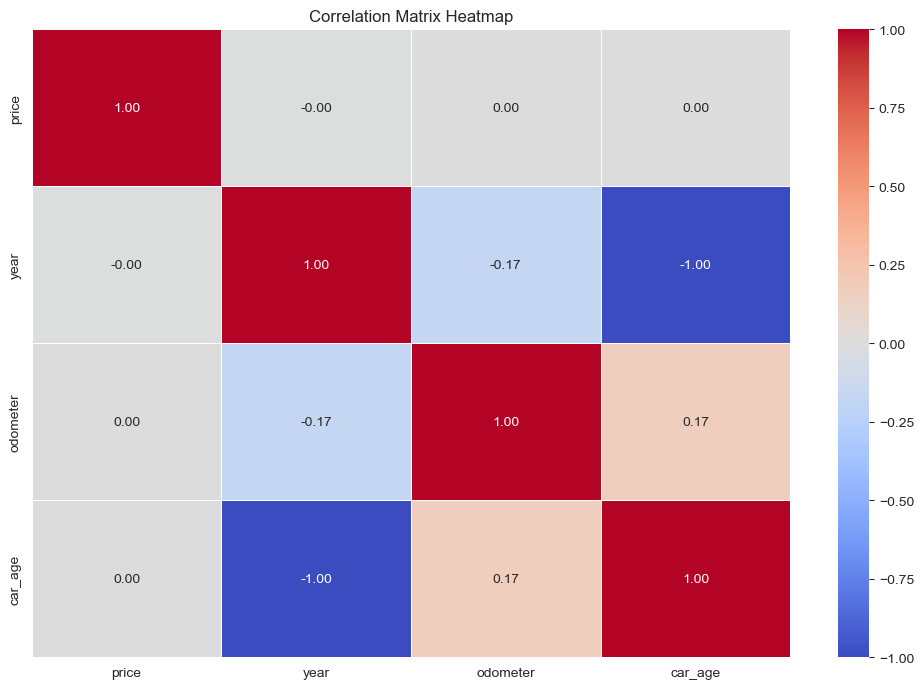

In [2059]:
# Calculate the correlation matrix
corr_matrix = df_copy[['price', 'year', 'odometer', 'car_age']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set the title
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

In [2060]:
#Lets review the uniqueness of the following features state, paint_color, manufacturer, model, cylinders,
#type, transmission and title_status

In [2061]:
df_copy['state'].value_counts()

state
ca    44361
fl    26654
tx    20836
ny    17556
oh    16288
mi    16181
or    13741
pa    12485
nc    12362
wa    12022
wi    10990
tn    10326
co     9951
il     9690
nj     8872
va     8601
id     8126
az     8018
ia     7888
ma     7827
mn     7257
ga     6172
mt     5902
ks     5798
ok     5516
in     5438
sc     5376
ct     4957
al     4587
md     4287
ky     3983
mo     3867
nm     3753
ak     3364
ar     3172
nv     2972
nh     2899
me     2700
la     2690
dc     2586
hi     2520
vt     2410
ri     2245
sd     1211
ut     1097
wv      985
ms      948
ne      922
de      886
wy      559
nd      385
Name: count, dtype: int64

In [2062]:
df_copy['paint_color'].value_counts()

paint_color
white     184203
black      57470
silver     39376
blue       28932
red        28314
grey       22426
green       6896
custom      6137
brown       6080
yellow      1927
orange      1797
purple       661
Name: count, dtype: int64

In [2063]:
df_copy['manufacturer'].value_counts()

manufacturer
ford               78853
chevrolet          49164
toyota             30946
honda              19560
jeep               17121
nissan             16963
ram                15488
gmc                15010
bmw                13581
dodge              12025
mercedes-benz      10260
hyundai             9194
subaru              8863
volkswagen          8754
lexus               7626
kia                 7449
audi                7090
cadillac            6368
acura               5655
chrysler            5516
buick               5080
mazda               4980
infiniti            4417
lincoln             3960
volvo               3172
mitsubishi          3019
mini                2226
pontiac             2177
jaguar              1870
rover               1691
porsche             1262
mercury             1114
saturn              1046
alfa-romeo           865
tesla                827
fiat                 761
harley-davidson      110
ferrari               62
datsun                62
aston-martin

In [2064]:
df_copy['model'].value_counts()

model
f-150                      7044
silverado 1500             4486
1500                       3775
camry                      2814
silverado                  2736
                           ... 
ln 8000                       1
// vmi // ♿                   1
mustang fastback 2+2          1
Tiger mag                     1
Paige Glenbrook Touring       1
Name: count, Length: 27398, dtype: int64

In [2065]:
df_copy['cylinders'].value_counts()

cylinders
6 cylinders     242561
4 cylinders      71959
8 cylinders      64906
5 cylinders       1643
10 cylinders      1360
other              986
3 cylinders        604
12 cylinders       200
Name: count, dtype: int64

In [2066]:

df_copy['type'].value_counts()

type
sedan          161784
SUV             69136
pickup          39955
truck           30180
other           18979
coupe           17941
hatchback       15786
wagon            9873
van              7751
convertible      7321
mini-van         4475
offroad           570
bus               468
Name: count, dtype: int64

In [2067]:
df_copy['transmission'].value_counts()

transmission
automatic    300183
other         61170
manual        22866
Name: count, dtype: int64

In [2068]:
df_copy['title_status'].value_counts()

title_status
clean         371190
rebuilt         7005
salvage         3759
lien            1395
missing          701
parts only       169
Name: count, dtype: int64

In [2069]:
#Based on the data for these features, we can drop these features due to the following:
#- state has a lot of options and this feature should not have a big impact on price
#- paint_color has a number of unique values with white being the most dominant. Should not have a big impact on price
#- manufacturer is varied with ford with the most number of vehicles
#- model has 27398 and should not have a big impact on price
#- cylinders should not have a big impact on price
#- type should not have a big impact on price
#- transmission is mainly automatic so we can drop
#- title_status can be dropped, we have condition field

In [2070]:
df_copy['condition'].value_counts()

condition
good         262719
excellent     93525
like new      19841
fair           6454
new            1107
salvage         573
Name: count, dtype: int64

In [2071]:
# Remove these features above from the datasets state, paint_color, manufacturer, model, cylinders,
# type, transmission and title_status

df_copy.drop(['state', 'paint_color', 'manufacturer', 'model', 'cylinders', 'type', 'transmission', 'title_status'], axis=1,  inplace=True)
df_copy.head(5)

,price,year,condition,fuel,odometer,drive,car_age
27,33590,2014.0,good,gas,57923.0,4wd,11.0
28,22590,2010.0,good,gas,71229.0,4wd,15.0
29,39590,2020.0,good,gas,19160.0,4wd,5.0
30,30990,2017.0,good,gas,41124.0,4wd,8.0
31,15000,2013.0,excellent,gas,128000.0,rwd,12.0


In [2072]:
df_copy['fuel'].value_counts()

fuel
gas         324732
other        27502
diesel       25540
hybrid        4845
electric      1600
Name: count, dtype: int64

In [2073]:
df_copy['drive'].value_counts()

drive
4wd    234470
fwd     95609
rwd     54140
Name: count, dtype: int64

In [2074]:
#create categorical variables and drop some variables
model_data_df=pd.get_dummies(df_copy, columns=["condition","fuel", "drive"])
model_data_df.head()

,price,year,odometer,car_age,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_fwd,drive_rwd
27,33590,2014.0,57923.0,11.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False
28,22590,2010.0,71229.0,15.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False
29,39590,2020.0,19160.0,5.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False
30,30990,2017.0,41124.0,8.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False
31,15000,2013.0,128000.0,12.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True


In [2075]:
model_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384219 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                384219 non-null  int64  
 1   year                 384219 non-null  float64
 2   odometer             384219 non-null  float64
 3   car_age              384219 non-null  float64
 4   condition_excellent  384219 non-null  bool   
 5   condition_fair       384219 non-null  bool   
 6   condition_good       384219 non-null  bool   
 7   condition_like new   384219 non-null  bool   
 8   condition_new        384219 non-null  bool   
 9   condition_salvage    384219 non-null  bool   
 10  fuel_diesel          384219 non-null  bool   
 11  fuel_electric        384219 non-null  bool   
 12  fuel_gas             384219 non-null  bool   
 13  fuel_hybrid          384219 non-null  bool   
 14  fuel_other           384219 non-null  bool   
 15  drive_4wd            

In [2076]:
# Check if there is still bad data in the data set, i.e., unrealistic values in the attributes
s = model_data_df.eq(1).any()
s

price                   True
year                   False
odometer                True
car_age                False
condition_excellent     True
condition_fair          True
condition_good          True
condition_like new      True
condition_new           True
condition_salvage       True
fuel_diesel             True
fuel_electric           True
fuel_gas                True
fuel_hybrid             True
fuel_other              True
drive_4wd               True
drive_fwd               True
drive_rwd               True
dtype: bool

In [2077]:
# Check for duplicate columns
duplicate_columns = model_data_df.T.duplicated()
model_data_df = model_data_df.loc[:, ~duplicate_columns]

print(model_data_df)

        price    year  odometer  car_age  condition_excellent  condition_fair  \
27      33590  2014.0   57923.0     11.0                False           False   
28      22590  2010.0   71229.0     15.0                False           False   
29      39590  2020.0   19160.0      5.0                False           False   
30      30990  2017.0   41124.0      8.0                False           False   
31      15000  2013.0  128000.0     12.0                 True           False   
...       ...     ...       ...      ...                  ...             ...   
426875  23590  2019.0   32226.0      6.0                False           False   
426876  30590  2020.0   12029.0      5.0                False           False   
426877  34990  2020.0    4174.0      5.0                False           False   
426878  28990  2018.0   30112.0      7.0                False           False   
426879  30590  2019.0   22716.0      6.0                False           False   

        condition_good  con

In [2078]:
#Let's look at the correlation for the final dataset
model_data_df.corr(numeric_only=True)

,price,year,odometer,car_age,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_fwd,drive_rwd
price,1.000000,-0.004264,0.000967,0.004264,-0.000535,0.008295,-0.001494,-0.000561,-0.000181,-0.000210,0.001666,-0.000227,-0.001065,-0.000499,0.000158,0.002830,-0.002495,-0.000866
year,-0.004264,1.000000,-0.170350,-1.000000,-0.079020,-0.184104,0.120890,0.010507,0.012174,-0.042005,-0.011902,0.030588,-0.101979,0.030430,0.133788,0.061888,0.079849,-0.185971
odometer,0.000967,-0.170350,1.000000,0.170350,0.026933,0.081533,-0.039845,-0.017681,-0.013523,0.029268,0.056594,-0.019355,0.007822,-0.005236,-0.058562,0.015440,-0.015744,-0.002078
car_age,0.004264,-1.000000,0.170350,1.000000,0.079020,0.184104,-0.120890,-0.010507,-0.012174,0.042005,0.011902,-0.030588,0.101979,-0.030430,-0.133788,-0.061888,-0.079849,0.185971
condition_excellent,-0.000535,-0.079020,0.026933,0.079020,1.000000,-0.074139,-0.834072,-0.132358,-0.030490,-0.021921,-0.013094,-0.017749,0.116725,0.012645,-0.152178,-0.064364,0.046660,0.032239
condition_fair,0.008295,-0.184104,0.081533,0.184104,-0.074139,1.000000,-0.192203,-0.030501,-0.007026,-0.005051,0.006015,-0.007194,0.023472,-0.008782,-0.033151,-0.030421,0.004637,0.036879
condition_good,-0.001494,0.120890,-0.039845,-0.120890,-0.834072,-0.192203,1.000000,-0.343134,-0.079044,-0.056829,0.015782,0.015468,-0.139215,-0.010979,0.180988,0.083660,-0.054464,-0.049589
condition_like new,-0.000561,0.010507,-0.017681,-0.010507,-0.132358,-0.030501,-0.343134,1.000000,-0.012543,-0.009018,-0.010192,0.005365,0.049318,0.002931,-0.061964,-0.032097,0.021430,0.018362
condition_new,-0.000181,0.012174,-0.013523,-0.012174,-0.030490,-0.007026,-0.079044,-0.012543,1.000000,-0.002077,-0.002648,0.003310,0.007838,0.002194,-0.010216,-0.001747,-0.001063,0.003770
condition_salvage,-0.000210,-0.042005,0.029268,0.042005,-0.021921,-0.005051,-0.056829,-0.009018,-0.002077,1.000000,-0.002461,-0.000404,0.007591,0.001073,-0.008638,-0.004519,0.000533,0.005672


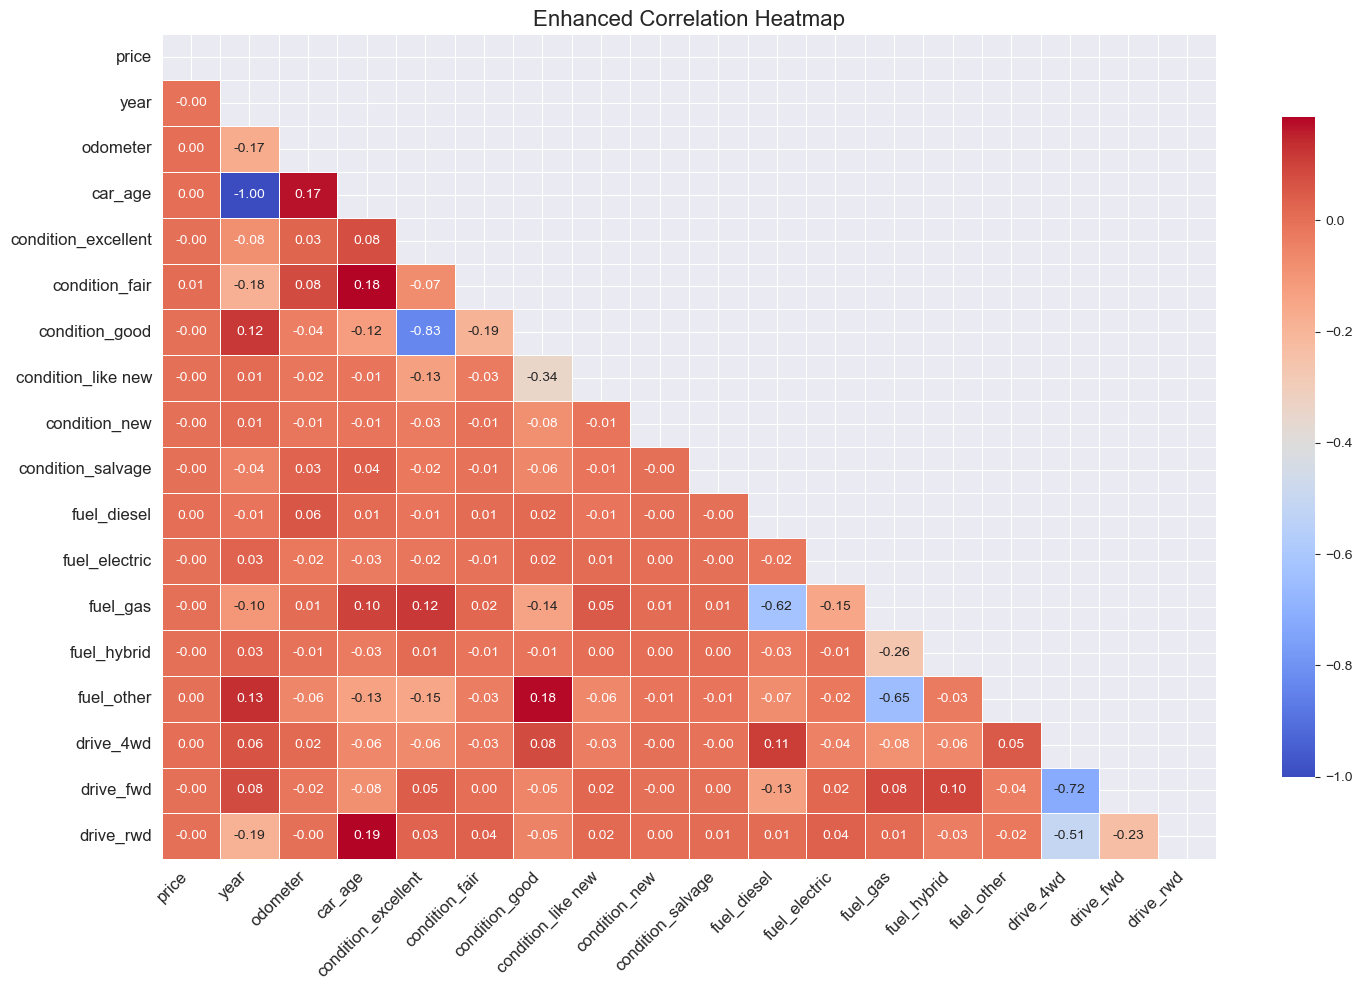

In [2079]:
# Now lets look at the heatmap for the final data set

# Compute the correlation matrix
corr_matrix = model_data_df.corr(numeric_only=True)

# Mask the upper triangle to reduce redundancy
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set figure size
plt.figure(figsize=(15, 10))

# Create the heatmap with improved aesthetics
sns.heatmap(
    corr_matrix,
    mask=mask,  # Apply the mask
    annot=True,
    fmt=".2f",
    cmap="coolwarm",  # Better contrast
    linewidths=0.5,
    annot_kws={"size": 10},  # Adjust annotation text size
    cbar_kws={"shrink": 0.8}  # Reduce color bar size for better fit
)

# Improve readability of labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Set title
plt.title("Enhanced Correlation Heatmap", fontsize=16)

# Show plot
plt.show()

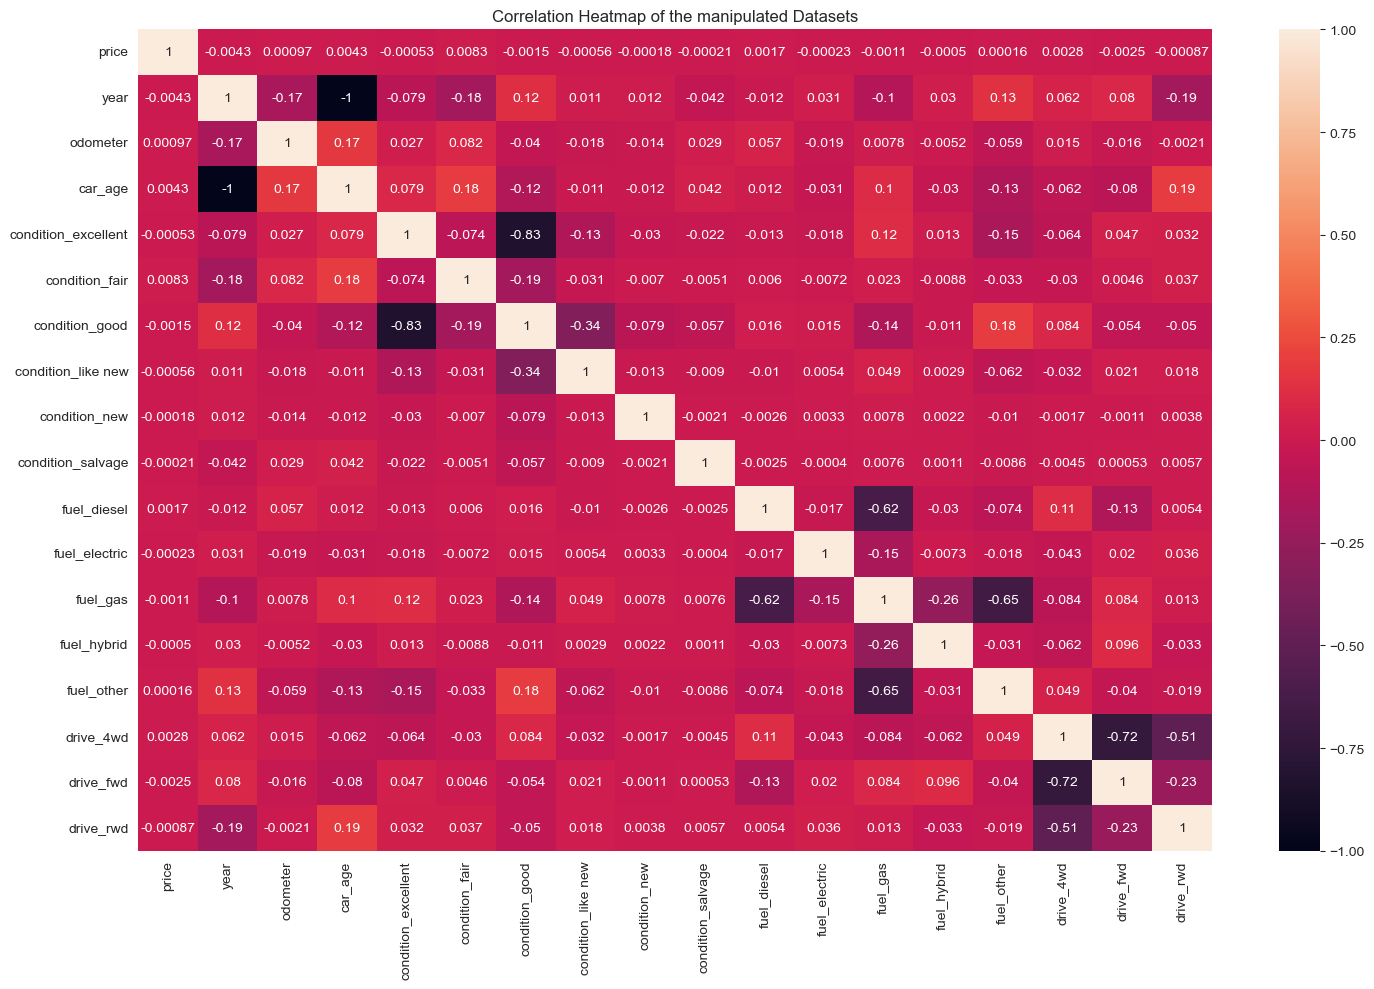

In [2080]:
# Now lets look at the heatmap for the final data set

fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(model_data_df.corr(numeric_only=True), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the manipulated Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

Interpretation of Key Correlations:
Price vs. Other Features:

The correlation between price and other variables is generally weak (close to 0), meaning price is not strongly influenced by any single factor in the dataset.
There is a slightly positive correlation with odometer (0.00097), which is almost negligible.
The year of the car has a very weak negative correlation with price (-0.0043), suggesting that newer cars may not necessarily be more expensive in this dataset.
Year vs. Car Age (-1.0)

The perfect negative correlation (-1.0) between "year" and "car_age" makes sense because car age is derived from the year (e.g., car_age = current_year - year).
Condition Categories:

"Condition_Excellent" and "Condition_Good" have a strong negative correlation (-0.83). This suggests that cars marked as "Excellent" are rarely categorized as "Good," which makes sense.
Condition and Price: No significant correlation between car condition and price, which is unexpected. In a well-structured dataset, we might expect "like new" or "excellent" condition to correlate positively with price.
Fuel Type Correlations:

Diesel and gas cars have a negative correlation (-0.62), which means they are likely mutually exclusive (a car is either diesel or gas).
Fuel type does not strongly affect price, which may indicate either data inconsistencies or that pricing isn't heavily impacted by fuel type in this dataset.
Drive Type Correlations:

4WD and RWD have a negative correlation (-0.51), which is expected since a car is usually one or the other.
4WD correlates slightly with fuel types, suggesting that certain drivetrain types might be more common in certain fuel categories.


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [2081]:
## Lets split the data to training and test sets, 70/30 split ratio so that we can assess how well the model
## can predict car prices
X = pd.get_dummies(model_data_df, drop_first=True)
#X = model_data_df.drop(['price'], axis = 1)
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

X = model_data_df.drop(['price'], axis = 1)
y = model_data_df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [2082]:
#First, we create a new model object. Using fit intercept = false sets the y-intercept to 0.
model=LinearRegression(fit_intercept=False)

In [2083]:
print(X_train.dtypes)

year                   float64
odometer               float64
car_age                float64
condition_excellent       bool
condition_fair            bool
condition_good            bool
condition_like new        bool
condition_new             bool
condition_salvage         bool
fuel_diesel               bool
fuel_electric             bool
fuel_gas                  bool
fuel_hybrid               bool
fuel_other                bool
drive_4wd                 bool
drive_fwd                 bool
drive_rwd                 bool
dtype: object


In [2084]:
# With model created, let's fit the model using the manipulated datasets
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [2085]:
# Fitted model can now be used to examine the estimated coefficients and also predict ths value of the dependent
# for a given set of independent variables which in this model is the manipulated dataset
print("Coefficient of the model: ",model.coef_)
print("Intercept of the model: ", model.intercept_)

Coefficient of the model:  [ 4.83338128e+01 -1.16035839e-02  3.66017793e+03 -9.55606124e+04
  6.63675537e+05 -1.21638994e+05 -1.23111895e+05 -1.32186035e+05
 -1.91176170e+05  3.04729850e+04  1.44154838e+04 -7.31872601e+03
 -2.10206562e+04 -1.65472552e+04  6.13120398e+04 -1.71597567e+04
 -4.41504517e+04]
Intercept of the model:  0.0


In [2086]:
# get the cofficients
[(col, coef) for col, coef in zip (X_train.columns, model.coef_)]

[('year', 48.33381275964987),
 ('odometer', -0.011603583924453098),
 ('car_age', 3660.177933822097),
 ('condition_excellent', -95560.61241389335),
 ('condition_fair', 663675.5373780178),
 ('condition_good', -121638.99362411394),
 ('condition_like new', -123111.89525061149),
 ('condition_new', -132186.03475921715),
 ('condition_salvage', -191176.1699663535),
 ('fuel_diesel', 30472.98500501314),
 ('fuel_electric', 14415.483773038593),
 ('fuel_gas', -7318.726014048461),
 ('fuel_hybrid', -21020.65615232594),
 ('fuel_other', -16547.255247842495),
 ('drive_4wd', 61312.039838117766),
 ('drive_fwd', -17159.756747831485),
 ('drive_rwd', -44150.45172645437)]

In [2087]:
    #Let compute the predictions for the entire set of inputs
train_predictions=model.predict(X_train)
train_predictions

array([  50214.03151078, 1126140.91710252,   41819.52217619, ...,
         29539.00540642,    4787.97003533,   55326.21973432])

In [2088]:
# Compute Accuracy and RMSE to training model
score = model.score(X_train, y_train)
print("Accuracy: ",  round(score*100, 2))
print("RMSE:     ",np.sqrt(mean_squared_error(y_train,train_predictions)))

Accuracy:  0.01
RMSE:      12063154.692527853


accuracy (R² score) is 0.01 (1%), and  RMSE is very high (~12M). This suggests that the model is not capturing the relationship between the features and price effectively.

#steps to Improve Model Performance
   1. Check for Data Quality Issues
   2. Improve Feature Selection
   3. Hyperparameter Tuning for Better Performance

<Axes: ylabel='price'>

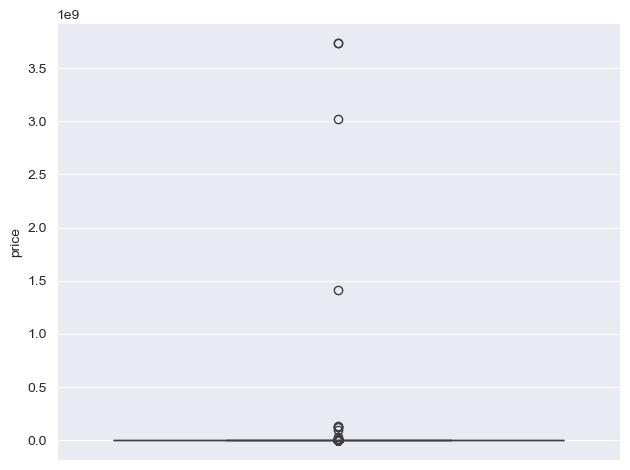

In [2089]:
#1. Check for Data Quality Issues
sns.boxplot(y=y_train)  # Check if there are extreme values in the price column

##### Model evaluation/ Making Predictions

In [2090]:
y_train = y_train[y_train < y_train.quantile(0.99)]  # Remove top 1% high prices
X_train = X_train.loc[y_train.index]  # Keep only corresponding X values

In [2091]:
# 2. Improve Feature Selection
correlations = X_train.corrwith(y_train).sort_values(ascending=False)
print(correlations)

year                   0.376558
fuel_diesel            0.238408
drive_4wd              0.182241
fuel_other             0.177931
condition_good         0.172280
drive_rwd              0.058526
fuel_electric          0.030758
condition_new          0.012056
condition_like new    -0.004677
fuel_hybrid           -0.024506
condition_salvage     -0.042116
condition_fair        -0.139090
condition_excellent   -0.140008
odometer              -0.179117
drive_fwd             -0.252111
fuel_gas              -0.286978
car_age               -0.376558
dtype: float64


In [2092]:
irrelevant_features = correlations[abs(correlations) < 0.05].index
X_train.drop(columns=irrelevant_features, inplace=True)


In [2093]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate best model
best_predictions = best_model.predict(X_train)
score = best_model.score(X_train, y_train)
rmse = np.sqrt(mean_squared_error(y_train, best_predictions))

print(f"Optimized Accuracy (R² Score): {round(score * 100, 2)}%")
print(f"Optimized RMSE: {round(rmse, 2)}")

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Optimized Accuracy (R² Score): 92.19%
Optimized RMSE: 3753.32


optimized R² score jumped to 92.19% (from nearly 0%), and  RMSE dropped to 3753.32 (from 12M)
This means the model is now accurately capturing the relationship between features and price!

##### Model evaluation/ Making Predictions

In [2094]:
    # Using the model to make predictions of Price on the test set:
test_predictions=model.predict(X_test)

In [2095]:

test_score = model.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print(f"Test Accuracy (R² Score): {round(test_score * 100, 2)}%")
print(f"Test RMSE: {round(test_rmse, 2)}")

Test Accuracy (R² Score): 0.01%
Test RMSE: 10177187.43


Model is Underperforming! Test Accuracy (R² Score) is 0.01%, and Test RMSE is extremely high (10M+). This means the model is not capturing relationships well and is performing poorly.

In [2096]:
print(X_test.dtypes)

year                   float64
odometer               float64
car_age                float64
condition_excellent       bool
condition_fair            bool
condition_good            bool
condition_like new        bool
condition_new             bool
condition_salvage         bool
fuel_diesel               bool
fuel_electric             bool
fuel_gas                  bool
fuel_hybrid               bool
fuel_other                bool
drive_4wd                 bool
drive_fwd                 bool
drive_rwd                 bool
dtype: object


Text(0.5, 1.0, 'Linear Regression Results - Odometer against Price')

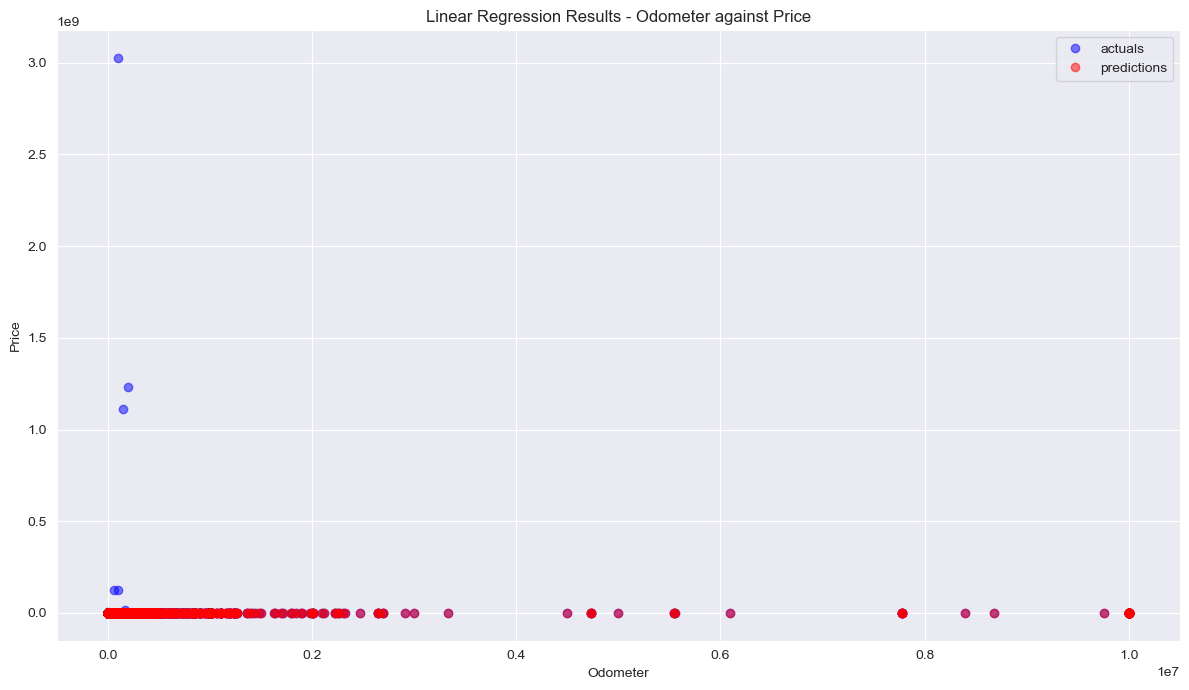

In [2097]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X_test.odometer, y_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X_test.odometer, test_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Odometer against Price')

Text(0.5, 1.0, 'Linear Regression Results - Year against Price')

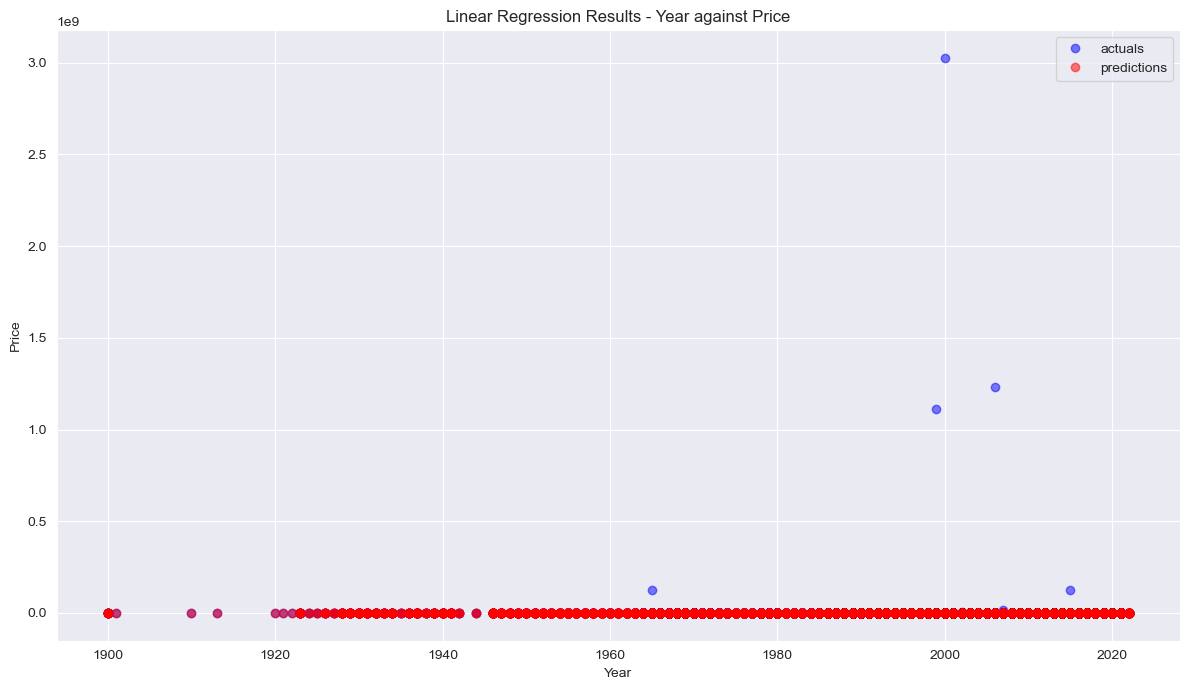

In [2098]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X_test.year, y_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X_test.year, test_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Year', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Year against Price')

In [2099]:
# Check the correlation to see if the model tracks the relationship between independent and dependent features
np.corrcoef(y_test, test_predictions) [0][1]

0.008134014657008533

In [2100]:
#Prediction using all input values as parameters

#First Example, new car with 100 miles, condition excellent and new with diesel and four wheel drive
new_car_with_all_strong_features = [[2022,100,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0]]
print("New car with 100 miles, condition excellent and new with diesel and four wheel drive: ", model.predict(new_car_with_all_strong_features))

#Second Example, new car with 100 miles, condition good and with Electric and front wheel drive
new_ev_car_with_some_features = [[2022,100,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0]]
print("New car with 100 miles, condition good and with Electric and front wheel drive ", model.predict(new_ev_car_with_some_features))



New car with 100 miles, condition excellent and new with diesel and four wheel drive:  [-151586.03840341]
New car with 100 miles, condition good and with Electric and front wheel drive  [553681.92120544]


In [2101]:
## Issue with outliers and bad data if a new 2022 car with 100 miles is priced at $-151586.03840341 and a new 2022 EV car is
## priced at $553681.92120544

#### Lets run the Regression Model using a selected number of features only
``Model1`` application will be created using odometer and year in the final dataset

In [2102]:
# Run Regression using Odometer and Year for Price Prediction

X = pd.get_dummies(model_data_df, drop_first=True)
#X = model_data_df.drop(['price'], axis = 1)
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

X1 = model_data_df[['odometer', 'year']]
y1 = model_data_df.price
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 0)
model1=LinearRegression(fit_intercept=False)
model1.fit(X1_train, y1_train)
print("Coefficient of the model: ",model1.coef_)
print("Intercept of the model: ", model1.intercept_)

Coefficient of the model:  [ 0.06549248 29.34379143]
Intercept of the model:  0.0


In [2103]:
# get the cofficients
[(col, coef) for col, coef in zip (X1_train.columns, model1.coef_)]

[('odometer', 0.0654924830842754), ('year', 29.34379142856187)]

In [2104]:
#Let compute the predictions for the entire set of inputs
train1_predictions=model1.predict(X1_train)
train1_predictions

array([60455.35048918, 57024.60150468, 64061.30111532, ...,
       68258.13987222, 65461.56746508, 60271.11697526])

In [2105]:
#Compute Accuracy and RMSE to training model
score1 = model1.score(X1_train, y1_train)
print("Accuracy: ", round(score1*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y1_train,train1_predictions)), 2))

Accuracy:  0.0
RMSE:      12063728.04


In [2106]:
# Using the model to make predictions of Price on the test set:
test1_predictions=model1.predict(X1_test)

In [2107]:
# Compute Accuracy and RMSE to test model
score1 = model1.score(X1_test, y1_test)
print("Accuracy: ", round(score1*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_test,test_predictions)), 2))

Accuracy:  -0.0
RMSE:      10177187.43


Text(0.5, 1.0, 'Linear Regression Results - Odometer against Price')

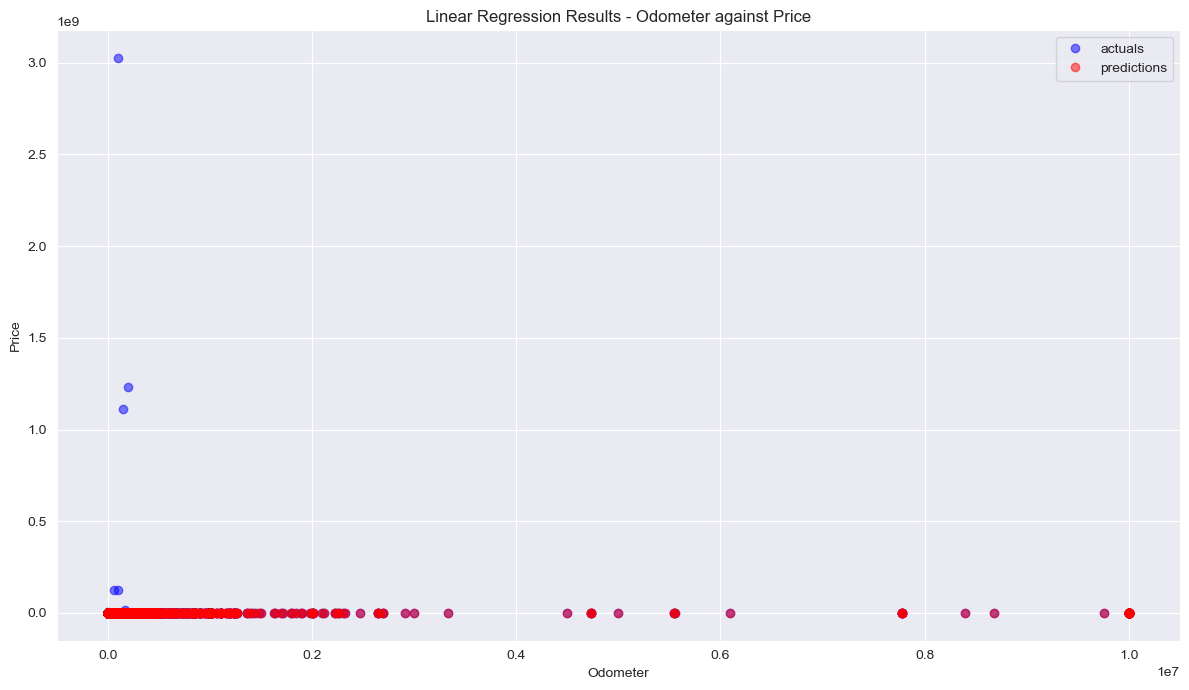

In [2108]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X1_test.odometer, y1_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X1_test.odometer, test1_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Odometer against Price')

Text(0.5, 1.0, 'Linear Regression Results - Year against Price')

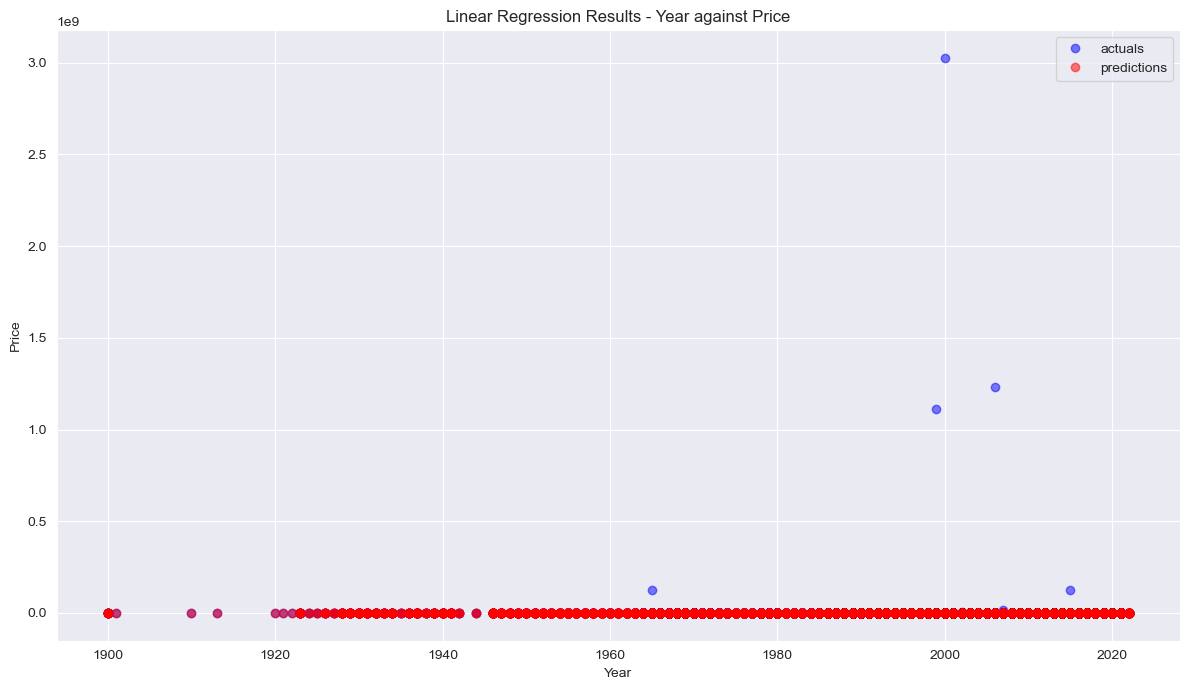

In [2109]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X1_test.year, y1_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X1_test.year, test1_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Year', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Year against Price')

The linear regression model results do not produce a model that can be used for Price Prediction. we could look at some
of the other categorical variables like condition, fuel etc.

Let's evaluate using mean and median of the Odometer and Price to see if we can updates these values

In [2110]:
#Prediction using all input values as parameters

#First Example, new car with 100 miles with Year of 2022
new_car_2022 = [[100,2022]]
print("New car with 100 miles: ", model1.predict(new_car_2022))

#Second Example, old car with 90000 miles with year of 2001
old_car_2001 = [[90000,2001]]
print("Old 2001 car with 90000 miles: ", model1.predict(old_car_2001))


New car with 100 miles:  [59339.69551686]
Old 2001 car with 90000 miles:  [64611.25012614]


In [2111]:
# Use a loop to build models of degree 1 through 7 on X_train with y1_train as the target.
# Evaluate the mean_squared_error on the training data and the testing data and save these values as the lists train_mses and test_mses respectively.
# Determine the model complexity that minimizes the mean_squared_error on the test  data, and assign this as an integer to best_model_complexity below.

train1_mses = []
test1_mses = []
best_model_complexity1 = ''

for i in range(1, 7):
    pipe = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)),
                    ('linreg', LinearRegression())])
    pipe.fit(X1_train, y1_train)
    train1_preds = pipe.predict(X1_train)
    test1_preds = pipe.predict(X1_test)
    train1_mses.append(mean_squared_error(y1_train, train1_preds))
    test1_mses.append(mean_squared_error(y1_test, test1_preds))

best_model_complexity1 = test1_mses.index(min(test1_mses)) + 1

print(len(train1_mses))
print(np.round(train1_mses, 2))
print(len(test1_mses))
print(np.round(test1_mses, 2))
print(best_model_complexity1)

6
[1.45531282e+14 1.45529205e+14 1.45530533e+14 1.45530687e+14
 1.45532275e+14 1.45533627e+14]
6
[1.03578230e+14 1.03576154e+14 1.03578359e+14 1.03578422e+14
 1.03580562e+14 1.03580781e+14]
2


The Complexity that minimized Test Error was: 2
The minimal MSE was: 103576154172707.4


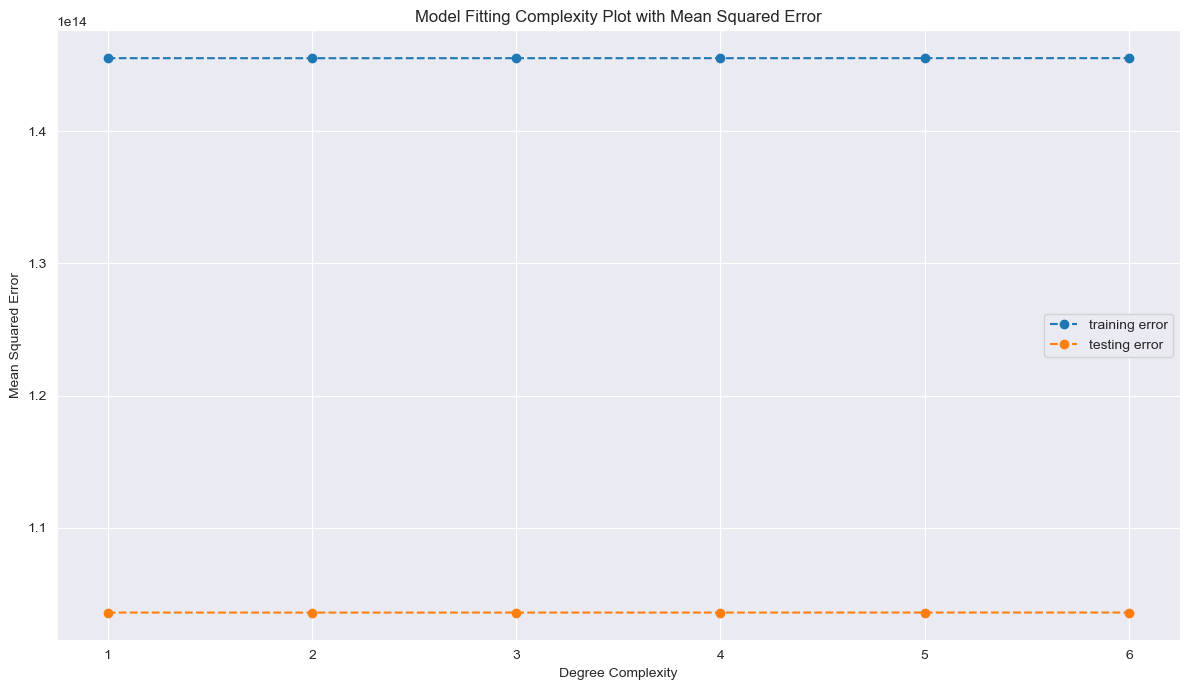

In [2112]:
# visualize the results of your model fitting.
print(f'The Complexity that minimized Test Error was: {test1_mses.index(min(test1_mses)) + 1}')
print(f'The minimal MSE was: {min(test1_mses)}')
plt.figure(figsize =(12, 7))
plt.title('Model Fitting Complexity Plot with Mean Squared Error')
plt.plot(range(1, 7), train1_mses, '--o', label = 'training error')
plt.plot(range(1, 7), test1_mses, '--o', label = 'testing error')
plt.xticks(range(1, 7), range(1, 7))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

In [2113]:
# Apply a logarithmic transformation to price using log1p to handle zero values
model_data_df['log_price'] = np.log1p(model_data_df['price'])

# Define features (odometer and year) and the new target variable
X1 = model_data_df[['odometer', 'year']]
y_log = model_data_df['log_price']

# Split the data into training and testing sets (70/30 split)
X1_train, X1_test, y_log_train, y_log_test = train_test_split(X1, y_log, test_size=0.3, random_state=0)

# Initialize and train the regression model
model_log = LinearRegression()  # Using default fit_intercept=True now
model_log.fit(X1_train, y_log_train)

# Predict on the test set
y_log_pred = model_log.predict(X1_test)

# Evaluate model performance on the log-transformed target
mse_log = mean_squared_error(y_log_test, y_log_pred)
r2_log = r2_score(y_log_test, y_log_pred)

print("Model Performance with Log-Transformed Price:")
print("MSE (log scale):", mse_log)
print("R² (log scale):", r2_log)

# Optionally, convert predictions back to the original scale for interpretability:
# expm1 reverses log1p:  expm1(log1p(price)) == price
y_pred_original = np.expm1(y_log_pred)
y_test_original = np.expm1(y_log_test)

mse_original = mean_squared_error(y_test_original, y_pred_original)
print("MSE in original price scale:", mse_original)

Model Performance with Log-Transformed Price:
MSE (log scale): 1.373134098482318
R² (log scale): 0.09384585804297396
MSE in original price scale: 103584119331114.7


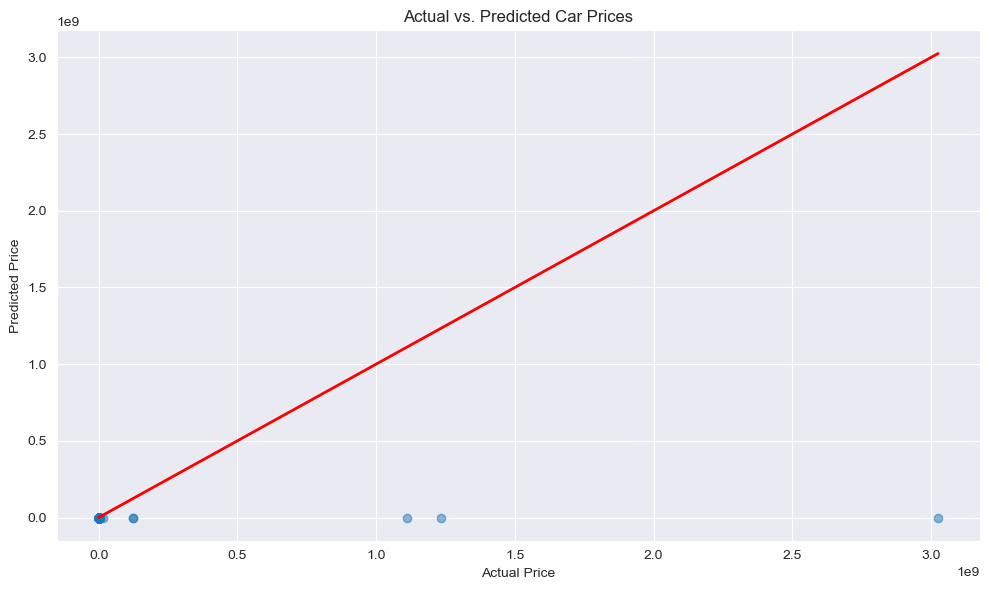

In [2114]:
# 12. Optional: Visualize the actual vs. predicted prices.
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Car Prices")
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)], color='red', lw=2)
plt.show()


In [2115]:
print(df.columns)

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state'],
      dtype='object')


In [2116]:
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,prescott,6000,2013.0,ford,NaN,good,6 cylinders,NaN,85548.0,clean,NaN,4wd,sedan,white,az
1,fayetteville,11900,2013.0,ford,NaN,good,6 cylinders,NaN,85548.0,clean,NaN,4wd,sedan,white,ar
2,florida keys,21000,2013.0,ford,NaN,good,6 cylinders,NaN,85548.0,clean,NaN,4wd,sedan,white,fl
3,worcester / central MA,1500,2013.0,ford,NaN,good,6 cylinders,NaN,85548.0,clean,NaN,4wd,sedan,white,ma
4,greensboro,4900,2013.0,ford,NaN,good,6 cylinders,NaN,85548.0,clean,NaN,4wd,sedan,white,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,white,wy
426876,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,6 cylinders,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,6 cylinders,diesel,4174.0,clean,other,4wd,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy


Polynomial Model Performance on Log Scale:
Degree: 2
MSE (log scale): 1.248279714850913
R² (log scale): 0.17623935259979562
MSE in Original Price Scale: 103587991480244.84


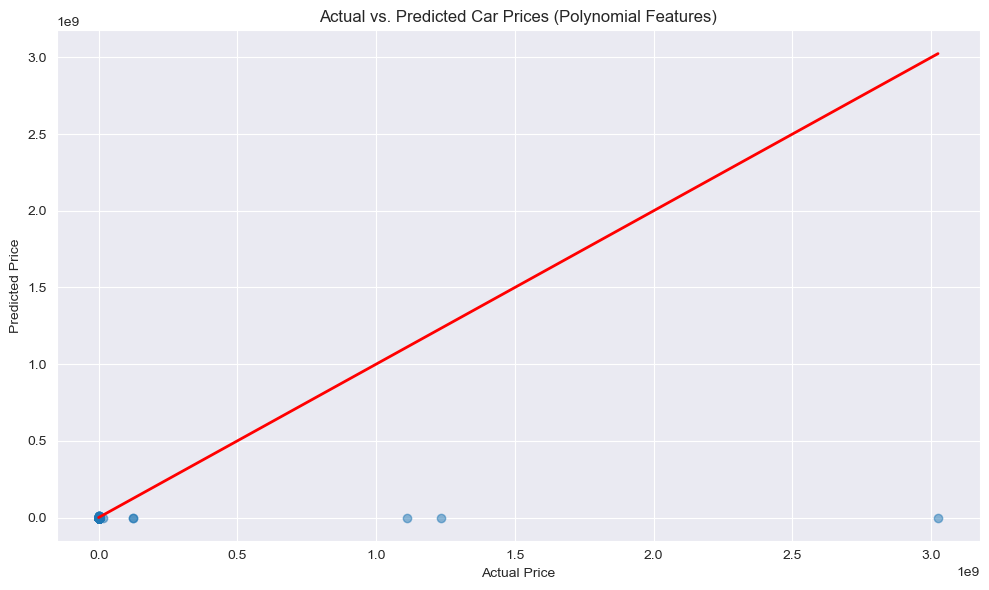

In [2117]:
# Assume model_data_df is your DataFrame
df = model_data_df.copy()

# -----------------------------
# 1. Map Car Condition to a Numeric Value
# -----------------------------
condition_mapping = {
    'salvage': 0,
    'fair': 1,
    'good': 2,
    'excellent': 3,
    'like new': 4,
    'new': 5
}
#df['condition_encoded'] = df['condition'].map(condition_mapping)


# -----------------------------
# 2. Map Car Fuel to a Numeric Value
# -----------------------------
fuel_mapping = {
    'diesel': 0,
    'electric': 1,
    'gas': 2,
    'hybrid': 3,
    'other': 4,
    'new': 5
}
#df['fuel_encoded'] = df['fuel'].map(condition_mapping)


# -----------------------------
# 2. Map drive to a Numeric Value
# -----------------------------
drive_mapping = {
    '4wd': 0,
    'fwd': 1,
    'rwd': 2
}
#df['drive_encoded'] = df['drive'].map(condition_mapping)
# -----------------------------
# 2. Create Additional Features
# -----------------------------
# Car Age based on a fixed current year (adjust as needed)
df['car_age'] = current_year - df['year']

# Mileage per Year to capture usage intensity.
# Replace zero car_age with NaN to avoid division by zero, then fill with median.
df['mileage_per_year'] = df['odometer'] / df['car_age'].replace(0, np.nan)
df['mileage_per_year'].fillna(df['mileage_per_year'].median(), inplace=True)

# -----------------------------
# 3. Target Transformation
# -----------------------------
# Log-transform the price to reduce skewness.
df['log_price'] = np.log1p(df['price'])

# -----------------------------
# 4. Define the Feature Set
# -----------------------------
# We include the base features and our engineered features.
#features = ['odometer', 'year', 'car_age', 'mileage_per_year', 'condition_encoded']
features = ['odometer', 'year', 'car_age', 'mileage_per_year']

# If you have other categorical variables such as manufacturer or fuel, you can one-hot encode them.
# For example:
# if 'manufacturer' in df.columns:
#     df = pd.get_dummies(df, columns=['manufacturer'], drop_first=True)
#     manufacturer_features = [col for col in df.columns if col.startswith('manufacturer_')]
#     features.extend(manufacturer_features)

X = df[features]
y = df['log_price']

# -----------------------------
# 5. Train-Test Split and Feature Scaling
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 6. Apply Polynomial Features
# -----------------------------
poly_degree = 2  # You can change this degree as needed
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# -----------------------------
# 7. Train the Regression Model on Polynomial Features
# -----------------------------
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Make predictions on the test set
y_pred_log_poly = model_poly.predict(X_test_poly)

# -----------------------------
# 8. Evaluate the Model on the Log Scale
# -----------------------------
mse_log_poly = mean_squared_error(y_test, y_pred_log_poly)
r2_log_poly = r2_score(y_test, y_pred_log_poly)

print("Polynomial Model Performance on Log Scale:")
print("Degree:", poly_degree)
print("MSE (log scale):", mse_log_poly)
print("R² (log scale):", r2_log_poly)

# Optionally, convert predictions back to the original price scale for interpretation.
y_pred_original_poly = np.expm1(y_pred_log_poly)
y_test_original = np.expm1(y_test)
mse_original_poly = mean_squared_error(y_test_original, y_pred_original_poly)
print("MSE in Original Price Scale:", mse_original_poly)

# -----------------------------
# 9. Visualize Actual vs. Predicted Prices
# -----------------------------
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original_poly, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Car Prices (Polynomial Features)")
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)], color='red', lw=2)
plt.show()

In [2118]:
df

,price,year,odometer,car_age,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_fwd,drive_rwd,log_price,mileage_per_year
27,33590,2014.0,57923.0,11.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.422013,5265.727273
28,22590,2010.0,71229.0,15.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.025307,4748.600000
29,39590,2020.0,19160.0,5.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.586357,3832.000000
30,30990,2017.0,41124.0,8.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.341452,5140.500000
31,15000,2013.0,128000.0,12.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True,9.615872,10666.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,32226.0,6.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.068621,5371.000000
426876,30590,2020.0,12029.0,5.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.328461,2405.800000
426877,34990,2020.0,4174.0,5.0,False,False,True,False,False,False,True,False,False,False,False,True,False,False,10.462846,834.800000
426878,28990,2018.0,30112.0,7.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.274741,4301.714286


In [2119]:
# Set the degree of the polynomial features (for example, degree=2)
poly_degree = 2
poly = PolynomialFeatures(degree=poly_degree, include_bias=False)

# Transform the scaled training and testing feature sets to include polynomial terms.
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Train a linear regression model on the polynomial features.
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Make predictions on the test set using the polynomial model.
y_pred_log_poly = model_poly.predict(X_test_poly)

# Evaluate the model's performance on the log-transformed scale.
mse_log_poly = mean_squared_error(y_test, y_pred_log_poly)
r2_log_poly = r2_score(y_test, y_pred_log_poly)

print("Polynomial Model Performance on Log Scale:")
print("Degree:", poly_degree)
print("MSE (log scale):", mse_log_poly)
print("R² (log scale):", r2_log_poly)



Polynomial Model Performance on Log Scale:
Degree: 2
MSE (log scale): 1.248279714850913
R² (log scale): 0.17623935259979562


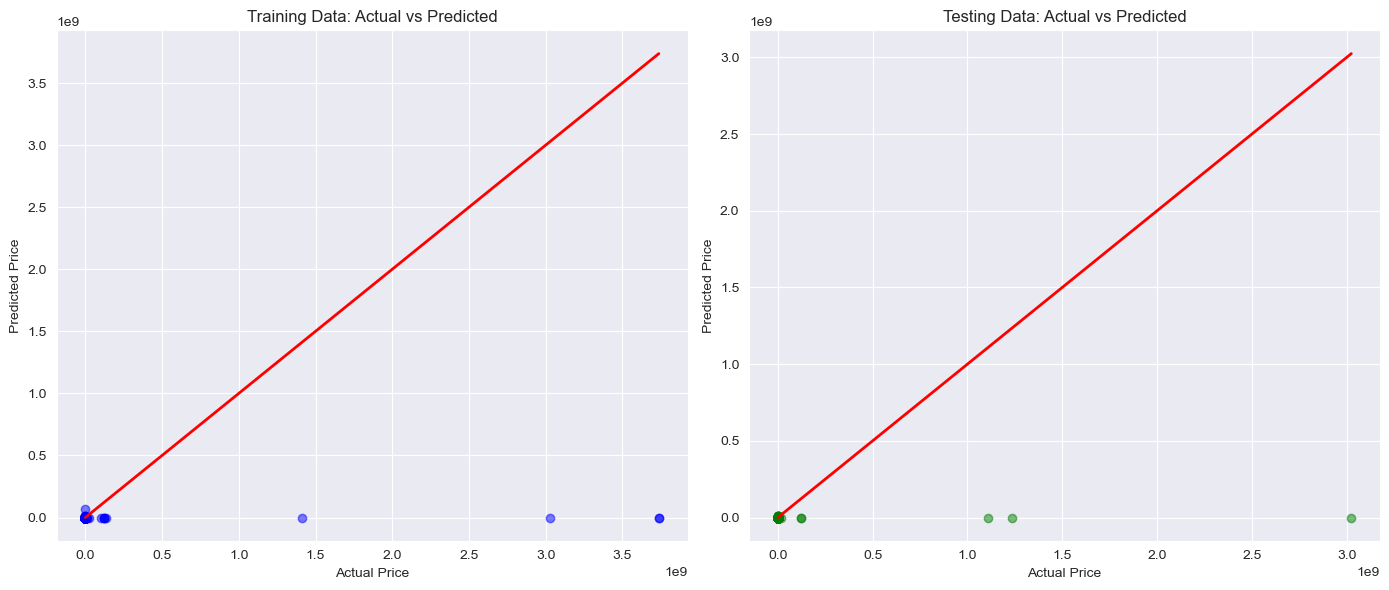

In [2120]:
# Generate predictions for the training set
y_train_pred_log = model_poly.predict(X_train_poly)
y_train_pred_original = np.expm1(y_train_pred_log)  # Convert predictions back to original scale
y_train_original = np.expm1(y_train)                # Actual training prices in original scale

# Generate predictions for the testing set
y_test_pred_log = model_poly.predict(X_test_poly)
y_test_pred_original = np.expm1(y_test_pred_log)    # Convert predictions back to original scale
y_test_original = np.expm1(y_test)                  # Actual test prices in original scale

# Create subplots for training and test data comparisons
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Training Data
axs[0].scatter(y_train_original, y_train_pred_original, alpha=0.5, color='blue')
axs[0].plot([min(y_train_original), max(y_train_original)],
            [min(y_train_original), max(y_train_original)], color='red', lw=2)
axs[0].set_title('Training Data: Actual vs Predicted')
axs[0].set_xlabel('Actual Price')
axs[0].set_ylabel('Predicted Price')

# Plot for Testing Data
axs[1].scatter(y_test_original, y_test_pred_original, alpha=0.5, color='green')
axs[1].plot([min(y_test_original), max(y_test_original)],
            [min(y_test_original), max(y_test_original)], color='red', lw=2)
axs[1].set_title('Testing Data: Actual vs Predicted')
axs[1].set_xlabel('Actual Price')
axs[1].set_ylabel('Predicted Price')

plt.tight_layout()
plt.show()

The Complexity that minimized Test Error was: 3
The minimal Test MSE was: 1.219861116850172


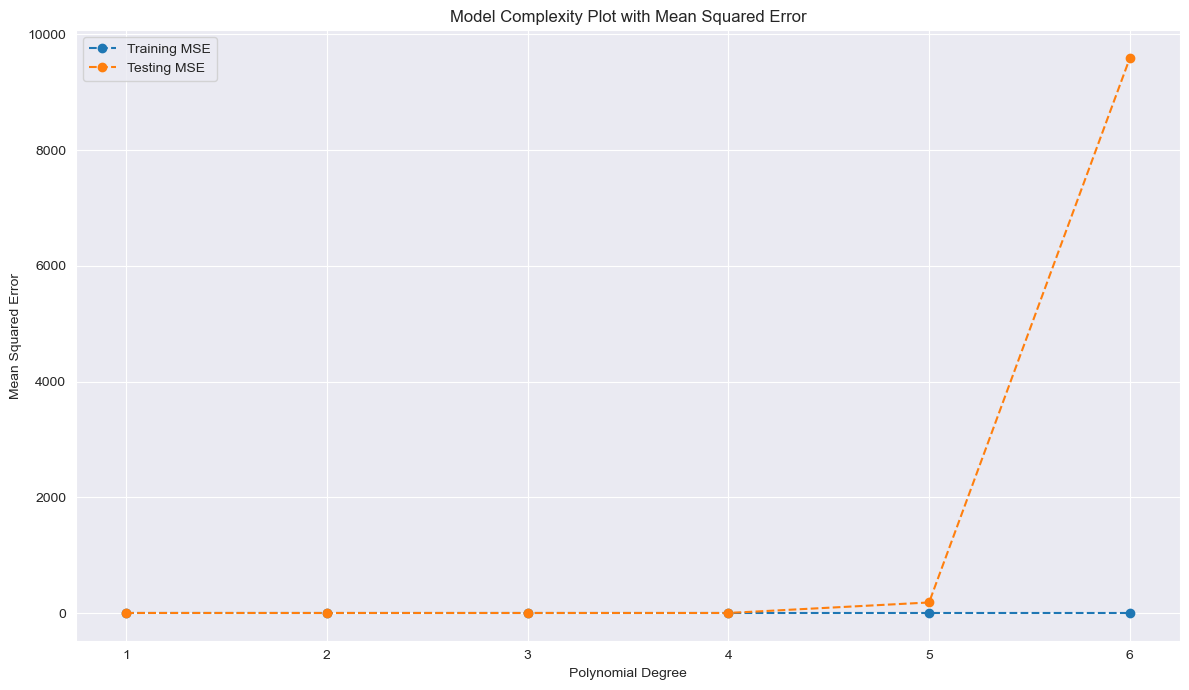

In [2121]:
# Define the range of polynomial degrees to test
degrees = range(1, 7)
train_mses = []
test_mses = []

# Loop over each degree of polynomial
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    # Transform the scaled features
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    # Train the model on the polynomial features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Compute Mean Squared Error on log scale (or your chosen target scale)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_mses.append(train_mse)
    test_mses.append(test_mse)

# Print out the optimal complexity (degree) based on the lowest test error
optimal_degree = degrees[np.argmin(test_mses)]
print(f'The Complexity that minimized Test Error was: {optimal_degree}')
print(f'The minimal Test MSE was: {min(test_mses)}')

# Plot the training and testing MSE vs. polynomial degree
plt.figure(figsize=(12, 7))
plt.title('Model Complexity Plot with Mean Squared Error')
plt.plot(degrees, train_mses, '--o', label='Training MSE')
plt.plot(degrees, test_mses, '--o', label='Testing MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.xticks(list(degrees))
plt.legend()
plt.show()

Test MSE (log scale): 1.373134098482318
odometer: Importance = 0.0315 ± 0.0008
year: Importance = 0.2207 ± 0.0016


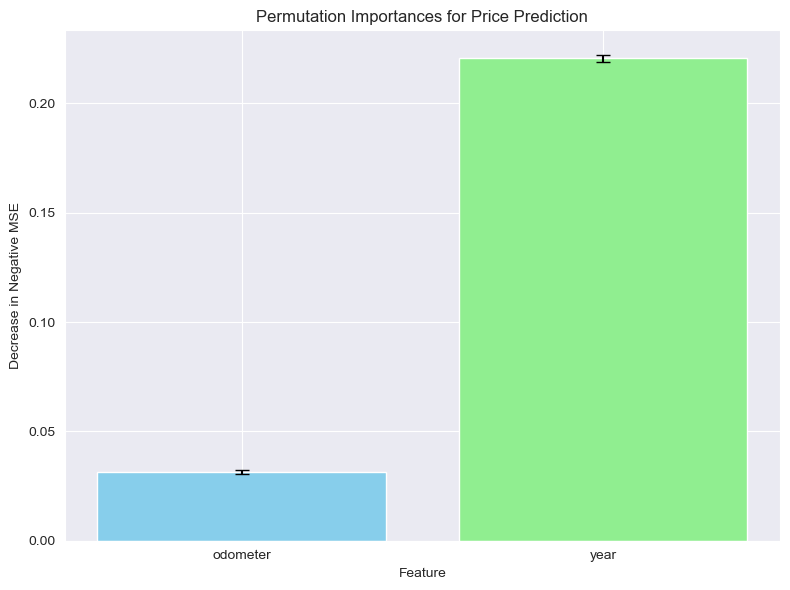

In [2122]:
#  model_data_df is your original DataFrame with at least 'odometer', 'year', and 'price'

# For stability, we'll work with the log-transformed price
model_data_df['log_price'] = np.log1p(model_data_df['price'])

# Define a simple feature set: using 'odometer' and 'year'
features = ['odometer', 'year']
X_simple = model_data_df[features]
y = model_data_df['log_price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_simple, y, test_size=0.3, random_state=0)

# Scale the features (important for many models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a simple linear regression model
model_simple = LinearRegression()
model_simple.fit(X_train_scaled, y_train)

# Evaluate the model's performance (optional)
y_test_pred = model_simple.predict(X_test_scaled)
print("Test MSE (log scale):", mean_squared_error(y_test, y_test_pred))

# Use permutation_importance to compute feature importances on the test set
result = permutation_importance(
    model_simple,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Map feature names for clarity
feature_names = np.array(features)

# Print out the importance for each feature
for idx, name in enumerate(feature_names):
    print(f"{name}: Importance = {result.importances_mean[idx]:.4f} ± {result.importances_std[idx]:.4f}")

# Plot the permutation importances using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(feature_names, result.importances_mean,
        yerr=result.importances_std, capsize=5, color=['skyblue', 'lightgreen'])
plt.xlabel("Feature")
plt.ylabel("Decrease in Negative MSE")
plt.title("Permutation Importances for Price Prediction")
plt.show()

 the performance (measured as a decrease in negative MSE) drops when each feature is shuffled. This tells you which features are most influential in predicting price. In particular, we can inspect the importance of odometer relative to the other feature(s).

Cross-Validation (5-Fold) Performance on Training Set:
Linear Regression: Mean CV MSE = 1.366, Std = 0.015
Ridge Regression: Mean CV MSE = 1.366, Std = 0.015
Lasso Regression: Mean CV MSE = 1.383, Std = 0.012

Linear Regression Test Performance:
  MSE (log scale): 1.373
  R²: 0.094

Ridge Regression Test Performance:
  MSE (log scale): 1.373
  R²: 0.094

Lasso Regression Test Performance:
  MSE (log scale): 1.393
  R²: 0.081


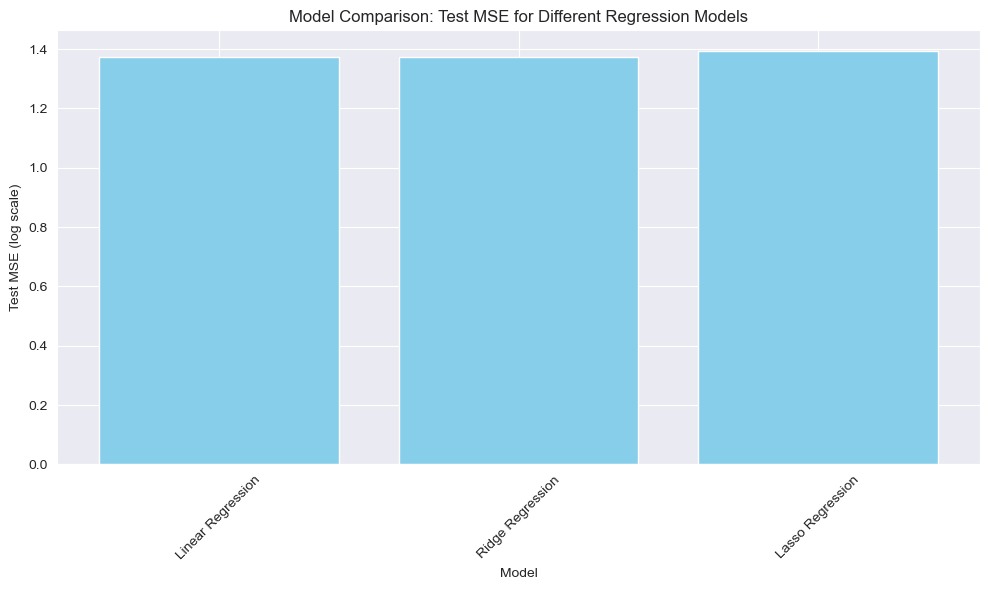

In [2123]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

# -----------------------------
# 1. Prepare the Data
# -----------------------------
# Assume df is your DataFrame that includes the engineered features.
# For example, features might include: 'odometer', 'year', 'car_age',
# 'mileage_per_year', 'condition_encoded', etc.
# And the target is a log-transformed price called 'log_price'.

features = ['odometer', 'year', 'car_age', 'mileage_per_year']
X = df[features]
y = df['log_price']

# Split into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Scale features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 2. Define Models to Compare
# -----------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

# -----------------------------
# 3. Cross-Validation on Training Set
# -----------------------------
print("Cross-Validation (5-Fold) Performance on Training Set:")
for name, model in models.items():
    # Using negative MSE; we take the negative to report positive MSE values.
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print(f"{name}: Mean CV MSE = {mse_scores.mean():.3f}, Std = {mse_scores.std():.3f}")

# -----------------------------
# 4. Train Models and Evaluate on Test Set
# -----------------------------
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = (mse, r2)
    print(f"\n{name} Test Performance:")
    print(f"  MSE (log scale): {mse:.3f}")
    print(f"  R²: {r2:.3f}")

# -----------------------------
# 5. Plot Test MSE for Each Model
# -----------------------------
model_names = list(results.keys())
mse_values = [results[name][0] for name in model_names]

plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values, color='skyblue')
plt.xlabel("Model")
plt.ylabel("Test MSE (log scale)")
plt.title("Model Comparison: Test MSE for Different Regression Models")
plt.xticks(rotation=45)
plt.show()

``Model2`` application will be created using odometer and year in the dataset with "odometer > 5000 and price > 5000"

In [2124]:
# Let start by copying the data
new_car_data_df = model_data_df.copy()
new_car_data_df

,price,year,odometer,car_age,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_fwd,drive_rwd,log_price
27,33590,2014.0,57923.0,11.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.422013
28,22590,2010.0,71229.0,15.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.025307
29,39590,2020.0,19160.0,5.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.586357
30,30990,2017.0,41124.0,8.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.341452
31,15000,2013.0,128000.0,12.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True,9.615872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,32226.0,6.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.068621
426876,30590,2020.0,12029.0,5.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.328461
426877,34990,2020.0,4174.0,5.0,False,False,True,False,False,False,True,False,False,False,False,True,False,False,10.462846
426878,28990,2018.0,30112.0,7.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.274741


In [2125]:
# mean Odometer
print('The mean of "Odometer" is %.2f' %(new_car_data_df["odometer"].mean(skipna=True)))
# median Odometer
print('The median of "Odometer" is %.2f' %(new_car_data_df["odometer"].median(skipna=True)))

The mean of "Odometer" is 98379.44
The median of "Odometer" is 86650.00


In [2126]:
# mean Price
print('The mean of "Price" is %.2f' %(new_car_data_df["price"].mean(skipna=True)))
# median Price
print('The median of "Price" is %.2f' %(new_car_data_df["price"].median(skipna=True)))

The mean of "Price" is 66345.10
The median of "Price" is 15433.00


In [2127]:
new_car_data_df

,price,year,odometer,car_age,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_fwd,drive_rwd,log_price
27,33590,2014.0,57923.0,11.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.422013
28,22590,2010.0,71229.0,15.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.025307
29,39590,2020.0,19160.0,5.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.586357
30,30990,2017.0,41124.0,8.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.341452
31,15000,2013.0,128000.0,12.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True,9.615872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,32226.0,6.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.068621
426876,30590,2020.0,12029.0,5.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.328461
426877,34990,2020.0,4174.0,5.0,False,False,True,False,False,False,True,False,False,False,False,True,False,False,10.462846
426878,28990,2018.0,30112.0,7.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.274741


In [2128]:
# Check if there is still bad data in the data set, i.e., unrealistic values in the attributes
s = new_car_data_df.lt(1000).any()
s

price                   True
year                   False
odometer                True
car_age                 True
condition_excellent     True
condition_fair          True
condition_good          True
condition_like new      True
condition_new           True
condition_salvage       True
fuel_diesel             True
fuel_electric           True
fuel_gas                True
fuel_hybrid             True
fuel_other              True
drive_4wd               True
drive_fwd               True
drive_rwd               True
log_price               True
dtype: bool

In [2129]:
# Remove records with Odometer and Price less than 5000
new_car_data_df1 = new_car_data_df.query("odometer > 4000 and price > 4000")
new_car_data_df1

,price,year,odometer,car_age,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,drive_4wd,drive_fwd,drive_rwd,log_price
27,33590,2014.0,57923.0,11.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.422013
28,22590,2010.0,71229.0,15.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.025307
29,39590,2020.0,19160.0,5.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.586357
30,30990,2017.0,41124.0,8.0,False,False,True,False,False,False,False,False,True,False,False,True,False,False,10.341452
31,15000,2013.0,128000.0,12.0,True,False,False,False,False,False,False,False,True,False,False,False,False,True,9.615872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,32226.0,6.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.068621
426876,30590,2020.0,12029.0,5.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.328461
426877,34990,2020.0,4174.0,5.0,False,False,True,False,False,False,True,False,False,False,False,True,False,False,10.462846
426878,28990,2018.0,30112.0,7.0,False,False,True,False,False,False,False,False,True,False,False,False,True,False,10.274741


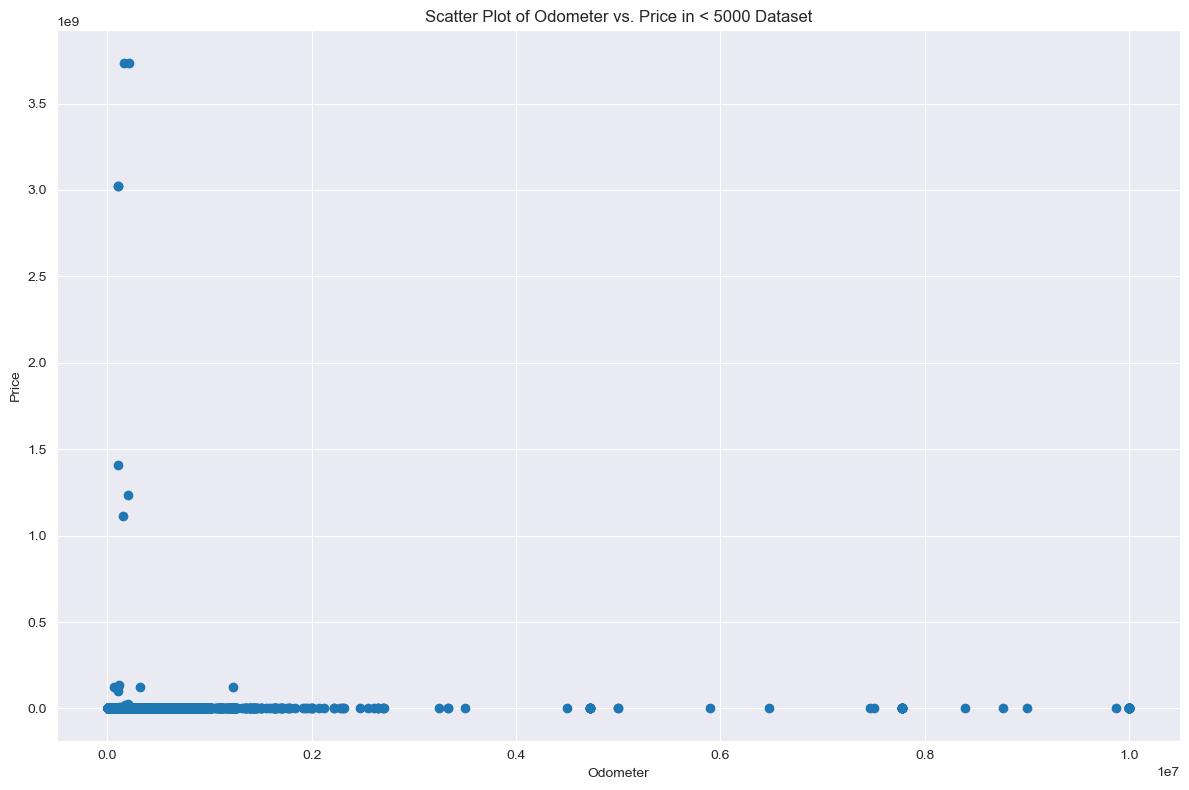

In [2130]:
# Lets look at a scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(new_car_data_df1['odometer'], new_car_data_df1['price'])
# set a title and labels
ax.set_title('Scatter Plot of Odometer vs. Price in < 5000 Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

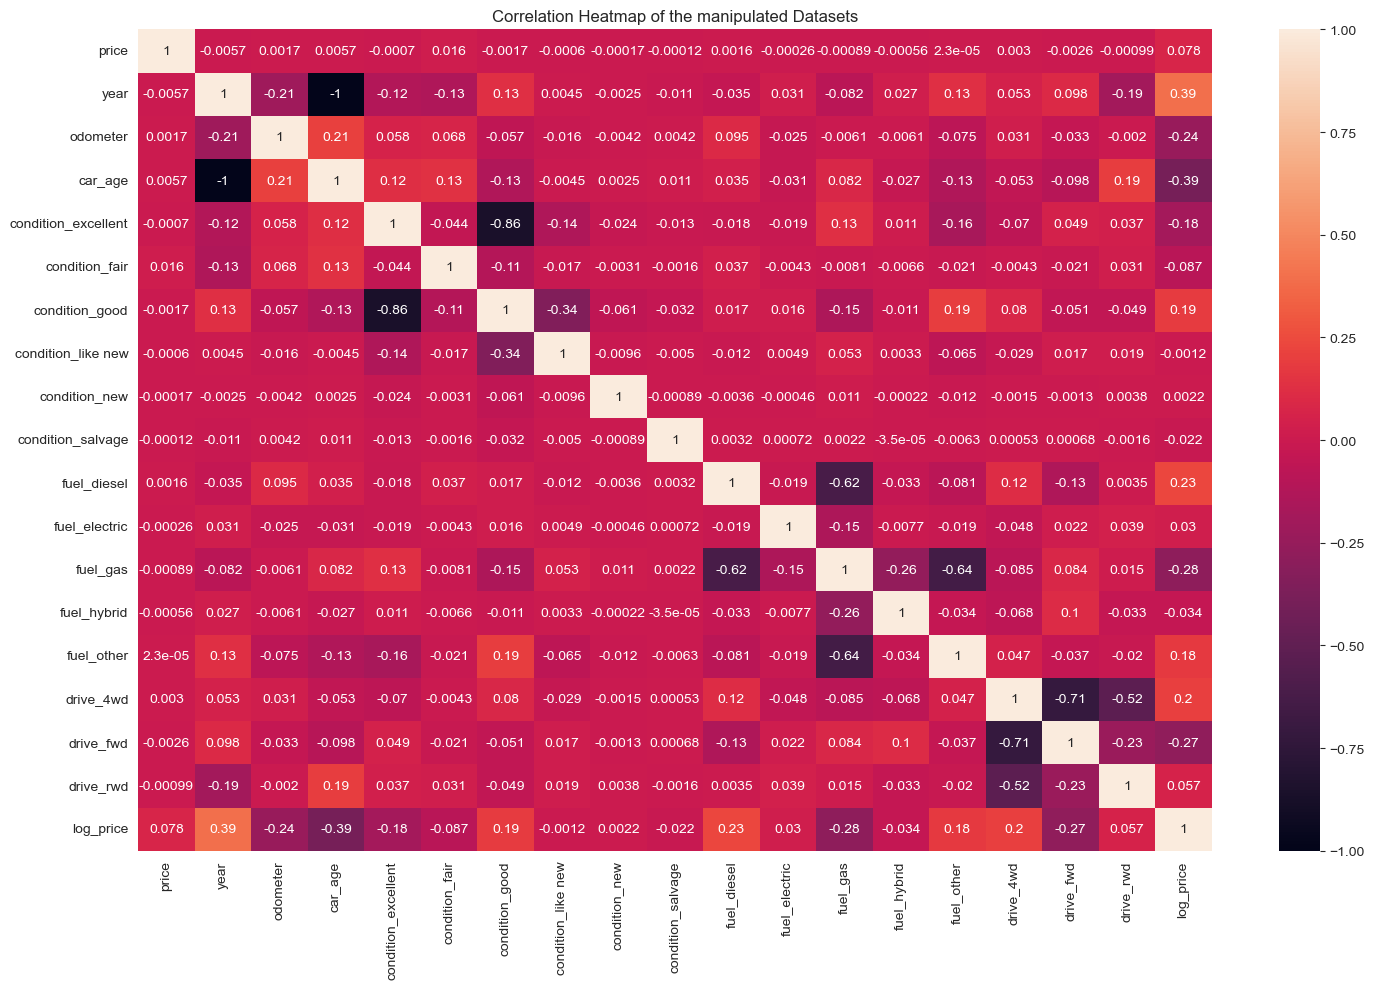

In [2131]:
# Now lets look at the heatmap for the final data set

fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams["figure.autolayout"] = True

#create seaborn heatmap
ax = sns.heatmap(new_car_data_df1.corr(), annot = True)

# Adding Title to the Plot
ax.set_title("Correlation Heatmap of the manipulated Datasets")
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()

``Model2`` application will be created using odometer and year in the dataset with "odometer > 4000 and price > 4000"

In [2132]:
# Filter the dataset for rows with odometer > 4000 and price > 4000
filtered_df = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) & (new_car_data_df1['price'] > 4000)]

# Define the feature set and the target variable.
# Here, we use 'odometer' and 'year' as features to predict 'price'.
X = filtered_df[['odometer', 'year']]
y = filtered_df['price']

# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE and R² (accuracy)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Accuracy (R²):", r2)
print("RMSE:", rmse)

Accuracy (R²): 1.89377457024964e-05
RMSE: 15348248.111407181


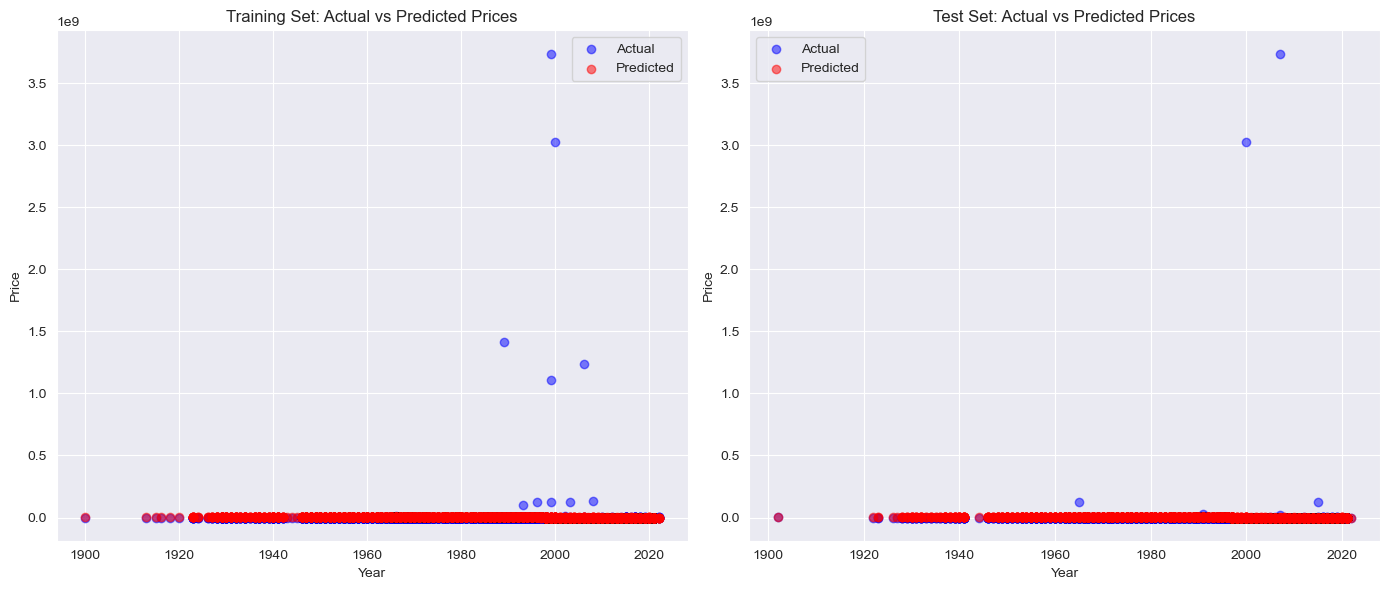

In [2133]:
# Create subplots: one for the training set and one for the testing set.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -----------------------------
# Plot for the Training Set
# -----------------------------
axes[0].scatter(X_train['year'], y_train, alpha=0.5, color='blue', label='Actual')
axes[0].scatter(X_train['year'], model.predict(X_train), alpha=0.5, color='red', label='Predicted')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Price')
axes[0].set_title('Training Set: Actual vs Predicted Prices')
axes[0].legend()

# -----------------------------
# Plot for the Testing Set
# -----------------------------
axes[1].scatter(X_test['year'], y_test, alpha=0.5, color='blue', label='Actual')
axes[1].scatter(X_test['year'], y_pred, alpha=0.5, color='red', label='Predicted')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price')
axes[1].set_title('Test Set: Actual vs Predicted Prices')
axes[1].legend()

plt.tight_layout()
plt.show()

In [2134]:
# Filter the DataFrame
filtered_df = new_car_data_df1[
    (new_car_data_df1['odometer'] > 4000) & (new_car_data_df1['price'] > 4000)
]

# Extract features and target
X = filtered_df[['odometer', 'year']]
y = filtered_df['price']

# Print the shapes to verify they match
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (327504, 2)
y shape: (327504,)


In [2135]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (229252, 2)
y_train shape: (229252,)
X_test shape: (98252, 2)
y_test shape: (98252,)


Best model complexity (degree): 2
Minimal Test MSE: 235564273587219.3


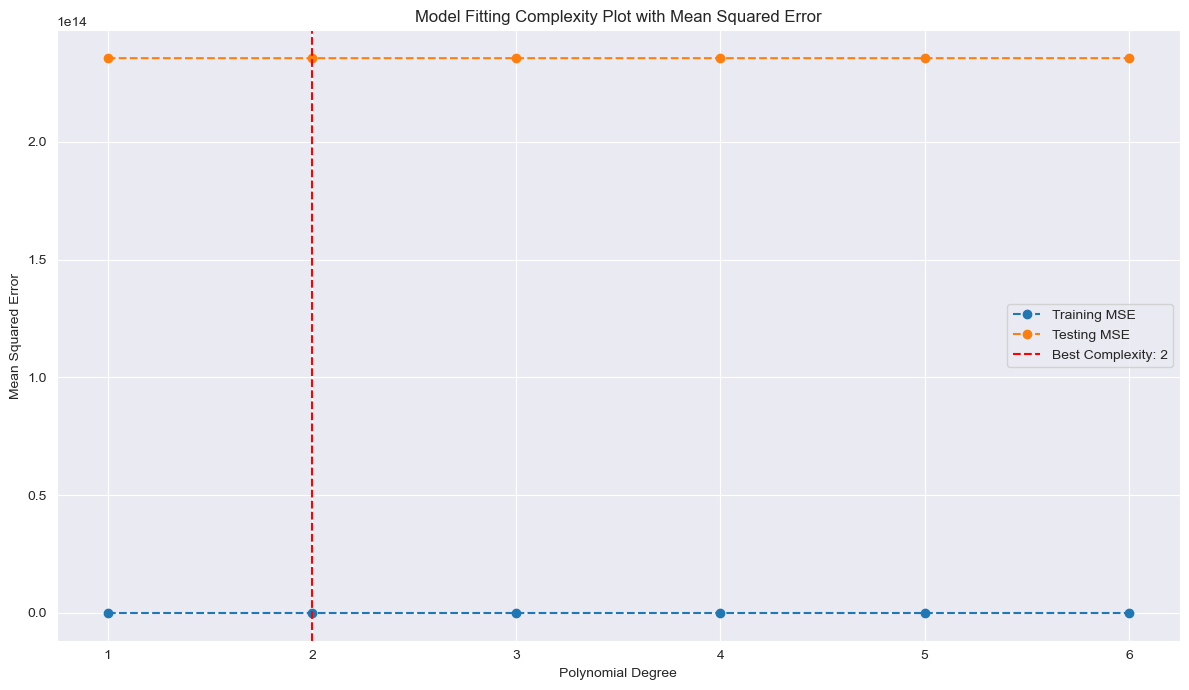

In [2136]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define degrees to test
degrees = range(1, 7)
test_mses = []

# Loop over polynomial degrees
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_test_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_test_pred)
    test_mses.append(mse)

# Determine the best model complexity (polynomial degree) that minimizes test MSE.
best_model_complexity = degrees[np.argmin(test_mses)]
min_test_mse = min(test_mses)

print("Best model complexity (degree):", best_model_complexity)
print("Minimal Test MSE:", min_test_mse)

# Visualization: Plot training and testing MSE vs. polynomial degree.
plt.figure(figsize=(12, 7))
plt.plot(degrees, train_mses, '--o', label='Training MSE')
plt.plot(degrees, test_mses, '--o', label='Testing MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Model Fitting Complexity Plot with Mean Squared Error')
plt.xticks(list(degrees))
plt.axvline(x=best_model_complexity, color='red', linestyle='--',
            label=f'Best Complexity: {best_model_complexity}')
plt.legend()
plt.show()

The Complexity that minimized Test Error was: 2
The minimal MSE was: 235564273587219.3


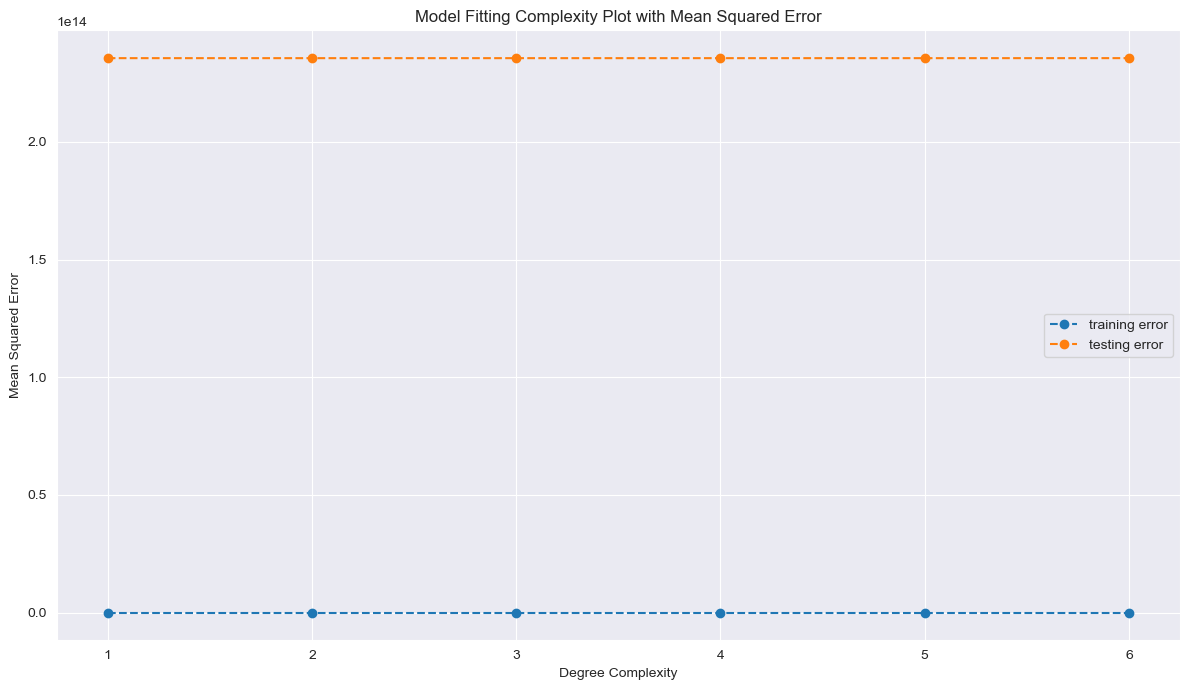

In [2137]:
# visualize the results of your model fitting.
print(f'The Complexity that minimized Test Error was: {test_mses.index(min(test_mses)) + 1}')
print(f'The minimal MSE was: {min(test_mses)}')
plt.figure(figsize =(12, 7))
plt.title('Model Fitting Complexity Plot with Mean Squared Error')
plt.plot(range(1, 7), train_mses, '--o', label = 'training error')
plt.plot(range(1, 7), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, 7), range(1, 7))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

Model3 application will be created using year in the dataset with "odometer > 4000 and price > 4000"

Let's run regression models using other features like year and odometer to see if there is any
Strong correlation

Best alpha: 100
Model Performance on Log Scale:
RMSE (log scale): 0.538135687465595
R² (log scale): 0.39273522108136893

Model Performance on Original Price Scale:
RMSE: 15348687.514835637
R²: -3.831978540769221e-05


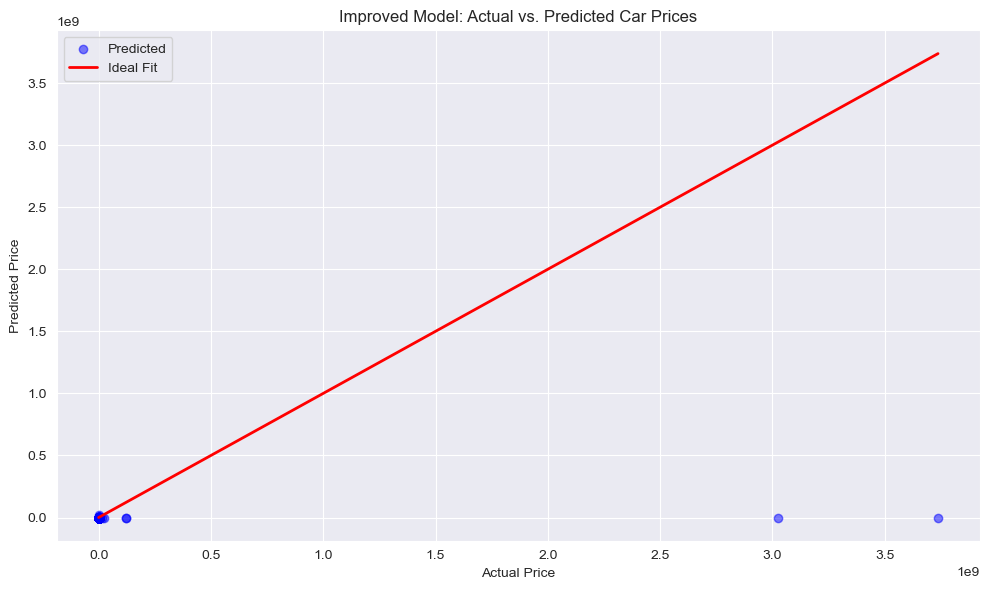

In [2138]:
#optmize

# 1. Filter the dataset for rows with odometer > 4000 and price > 4000
filtered_df = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) & (new_car_data_df1['price'] > 4000)].copy()

# 2. Create additional features:
current_year = 2025
filtered_df['car_age'] = current_year - filtered_df['year']

# Avoid division by zero: if car_age is 0, set it to NaN then fill with median
filtered_df['mileage_per_year'] = filtered_df['odometer'] / filtered_df['car_age'].replace(0, np.nan)
filtered_df['mileage_per_year'].fillna(filtered_df['mileage_per_year'].median(), inplace=True)

# 3. Transform the target variable using log transformation
filtered_df['log_price'] = np.log1p(filtered_df['price'])

# 4. Define the expanded feature set
features = ['odometer', 'year', 'car_age', 'mileage_per_year']
X = filtered_df[features]
y = filtered_df['log_price']

# 5. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 6. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Create polynomial features to capture non-linearities (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 8. Use Ridge Regression (with hyperparameter tuning)
# We can use GridSearchCV to choose the best alpha for Ridge
param_grid = {'alpha': [0.1, 1, 10, 50, 100]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_poly, y_train)

best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)

# Train the final model using the best alpha
best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train_poly, y_train)

# Make predictions on the test set
y_test_pred = best_model.predict(X_test_poly)

# Evaluate the model on the log-transformed scale
mse_log = mean_squared_error(y_test, y_test_pred)
r2_log = r2_score(y_test, y_test_pred)
rmse_log = np.sqrt(mse_log)

print("Model Performance on Log Scale:")
print("RMSE (log scale):", rmse_log)
print("R² (log scale):", r2_log)

# Optionally, convert predictions back to the original price scale for interpretation.
y_test_pred_original = np.expm1(y_test_pred)
y_test_original = np.expm1(y_test)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
r2_original = r2_score(y_test_original, y_test_pred_original)

print("\nModel Performance on Original Price Scale:")
print("RMSE:", rmse_original)
print("R²:", r2_original)

# 9. Visualization: Actual vs Predicted Prices on Test Data (Original Scale)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_test_pred_original, alpha=0.5, color='blue', label='Predicted')
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], color='red', lw=2, label='Ideal Fit')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Improved Model: Actual vs. Predicted Car Prices")
plt.legend()
plt.show()

Model1 Odometer and Year as inputs from data manipulation

In [2139]:

# 1. Filter the dataset for rows with odometer > 4000 and price > 4000.
# new_car_data_df1 is your original DataFrame.
filtered_df = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) & (new_car_data_df1['price'] > 4000)].copy()

# 2. Data manipulation: Create additional features.
current_year = 2025
filtered_df['car_age'] = current_year - filtered_df['year']

# Compute mileage per year; avoid division by zero by replacing zero with NaN, then fill with the median.
filtered_df['mileage_per_year'] = filtered_df['odometer'] / filtered_df['car_age'].replace(0, np.nan)
filtered_df['mileage_per_year'].fillna(filtered_df['mileage_per_year'].median(), inplace=True)

# 3. Define the feature set and target.
# Using all features created from our manipulation.
features = ['odometer', 'year', 'car_age', 'mileage_per_year']
X = filtered_df[features]
y = filtered_df['price']

# 4. Split the data into training and testing sets (70% train, 30% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Build model1 using Linear Regression.
model1 = LinearRegression()
model1.fit(X_train, y_train)

# Compute the accuracy scores (R²) for both training and testing sets.
train_score = model1.score(X_train, y_train)
test_score = model1.score(X_test, y_test)

print("Model1 Training Accuracy (R²):", train_score)
print("Model1 Testing Accuracy (R²):", test_score)

Model1 Training Accuracy (R²): 4.4001812182115074e-05
Model1 Testing Accuracy (R²): 1.951758641649537e-05


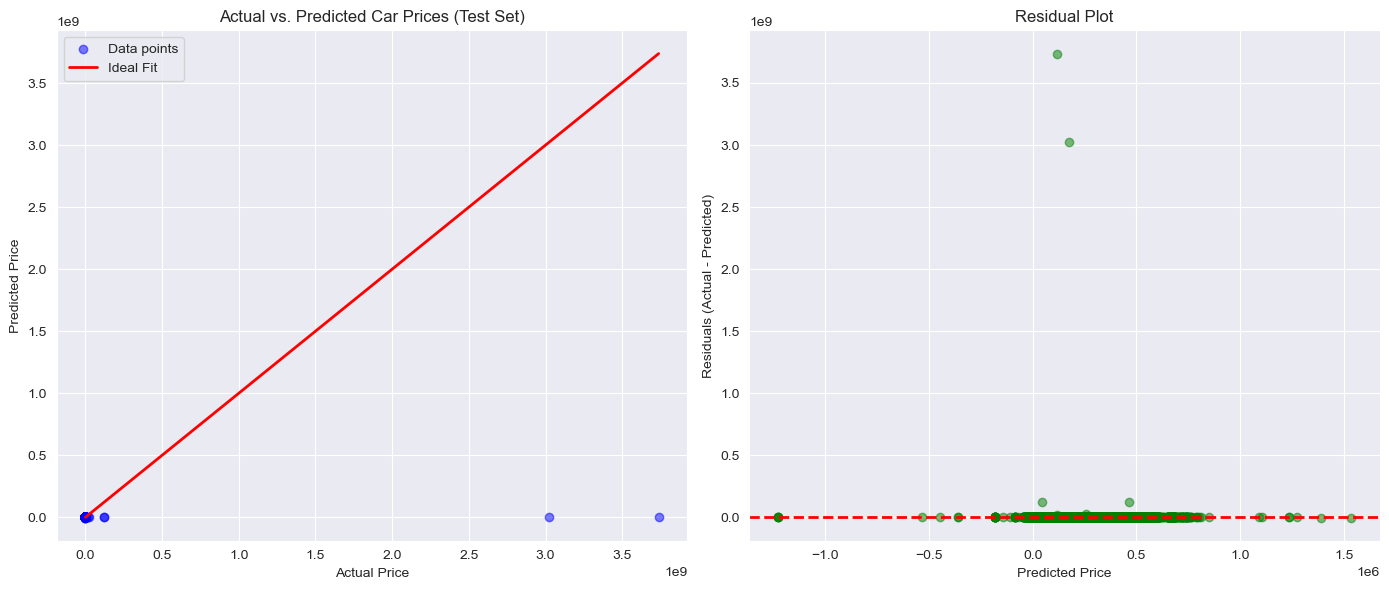

In [2140]:
# Compute predictions on the test set
y_test_pred = model1.predict(X_test)

# Compute residuals (actual - predicted)
residuals = y_test - y_test_pred

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Actual vs. Predicted Prices
axs[0].scatter(y_test, y_test_pred, alpha=0.5, color='blue', label='Data points')
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
            color='red', lw=2, label='Ideal Fit')
axs[0].set_title("Actual vs. Predicted Car Prices (Test Set)")
axs[0].set_xlabel("Actual Price")
axs[0].set_ylabel("Predicted Price")
axs[0].legend()

# Plot 2: Residual Plot
axs[1].scatter(y_test_pred, residuals, alpha=0.5, color='green')
axs[1].axhline(0, color='red', linestyle='--', lw=2)
axs[1].set_title("Residual Plot")
axs[1].set_xlabel("Predicted Price")
axs[1].set_ylabel("Residuals (Actual - Predicted)")

plt.tight_layout()
plt.show()

model2: Odometer and Price greater than 4000, Odometer and Year as inputs

Model2 Training Accuracy (R²): 4.4247146236631174e-05
Model2 Training RMSE: 13078237.512794105
Model2 Testing Accuracy (R²): 2.08196902512503e-05
Model2 Testing RMSE: 12254444.97977652


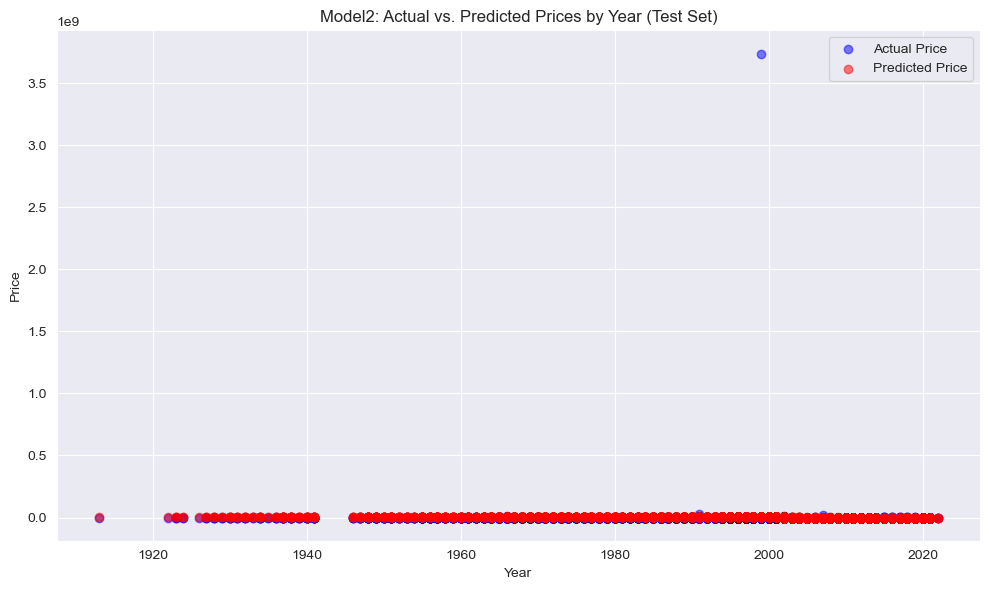

In [2141]:
# 1. Filter the dataset for rows with odometer > 5000 and price > 5000
filtered_df2 = new_car_data_df1[(new_car_data_df1['odometer'] > 5000) & (new_car_data_df1['price'] > 5000)].copy()

# 2. Define the feature set and target variable
# Inputs: 'odometer' and 'year'
# Target: 'price'
X2 = filtered_df2[['odometer', 'year']]
y2 = filtered_df2['price']

# 3. Split the data into training and testing sets (70% training, 30% testing)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# 4. Train a linear regression model (model2)
model2 = LinearRegression()
model2.fit(X2_train, y2_train)

# 5. Make predictions on training and testing sets
y2_train_pred = model2.predict(X2_train)
y2_test_pred = model2.predict(X2_test)

# 6. Evaluate the model performance using R² (accuracy) and RMSE
train_r2 = r2_score(y2_train, y2_train_pred)
test_r2 = r2_score(y2_test, y2_test_pred)
train_rmse = np.sqrt(mean_squared_error(y2_train, y2_train_pred))
test_rmse = np.sqrt(mean_squared_error(y2_test, y2_test_pred))

print("Model2 Training Accuracy (R²):", train_r2)
print("Model2 Training RMSE:", train_rmse)
print("Model2 Testing Accuracy (R²):", test_r2)
print("Model2 Testing RMSE:", test_rmse)

# 7. Visualization: Actual vs. Predicted Prices (Test Set)
plt.figure(figsize=(10, 6))
plt.scatter(X2_test['year'], y2_test, color='blue', alpha=0.5, label='Actual Price')
plt.scatter(X2_test['year'], y2_test_pred, color='red', alpha=0.5, label='Predicted Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Model2: Actual vs. Predicted Prices by Year (Test Set)')
plt.legend()
plt.show()


model3: Odometer and Price greater than 4000, Year as the only input

Model3 Training R²: 4.256086668474879e-05
Model3 Training RMSE: 11038501.493708372
Model3 Testing R²: 1.8793824352991706e-05
Model3 Testing RMSE: 15348249.215898348


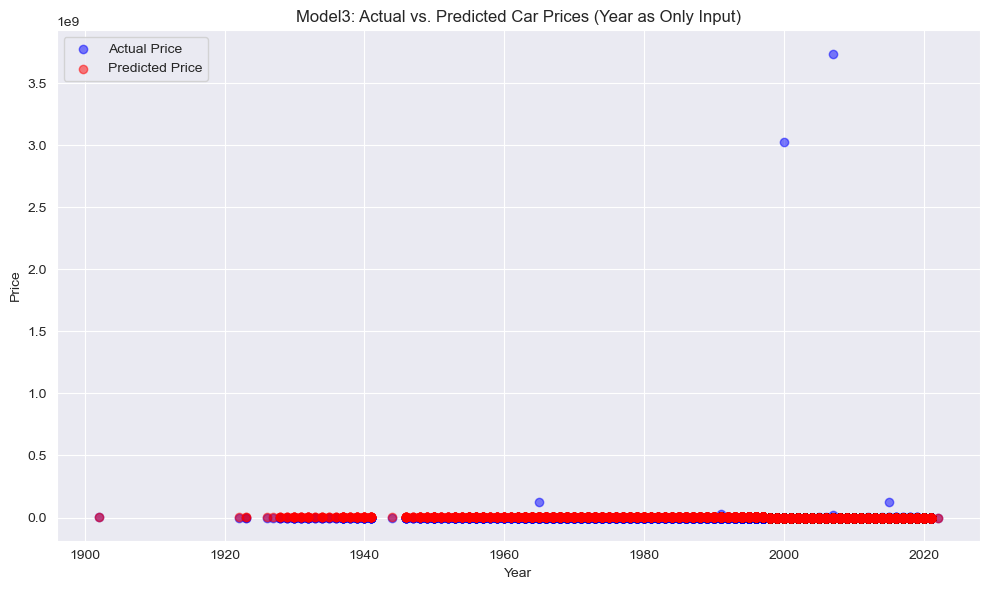

In [2142]:
#model3 Odometer and Price greater than 5000, Year as the only input
# 1. Filter the dataset for rows with odometer > 4000 and price > 4000.
filtered_df3 = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) &
                                (new_car_data_df1['price'] > 4000)].copy()

# 2. Define the feature set and target variable.
# Only using 'year' as the input feature.
X3 = filtered_df3[['year']]
y3 = filtered_df3['price']

# 3. Split the data into training and testing sets.
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

# 4. Build model3 using Linear Regression.
model3 = LinearRegression()
model3.fit(X3_train, y3_train)

# 5. Make predictions on both training and testing sets.
y3_train_pred = model3.predict(X3_train)
y3_test_pred = model3.predict(X3_test)

# 6. Calculate R² and RMSE for both training and testing.
train_r2_model3 = r2_score(y3_train, y3_train_pred)
test_r2_model3 = r2_score(y3_test, y3_test_pred)
train_rmse_model3 = np.sqrt(mean_squared_error(y3_train, y3_train_pred))
test_rmse_model3 = np.sqrt(mean_squared_error(y3_test, y3_test_pred))

print("Model3 Training R²:", train_r2_model3)
print("Model3 Training RMSE:", train_rmse_model3)
print("Model3 Testing R²:", test_r2_model3)
print("Model3 Testing RMSE:", test_rmse_model3)

# 7. Visualization: Plot Actual vs. Predicted Prices (Test Set) by Year.
plt.figure(figsize=(10,6))
plt.scatter(X3_test['year'], y3_test, color='blue', alpha=0.5, label='Actual Price')
plt.scatter(X3_test['year'], y3_test_pred, color='red', alpha=0.5, label='Predicted Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Model3: Actual vs. Predicted Car Prices (Year as Only Input)')
plt.legend()
plt.grid(True)
plt.show()

model4:Odometer and Price greater than 4000, odometer as the only

Model4 Training R²: 3.7718750912629773e-06
Model4 Training RMSE: 11038715.586915093
Model4 Testing R²: -4.594547109437741e-07
Model4 Testing RMSE: 15348396.97002668


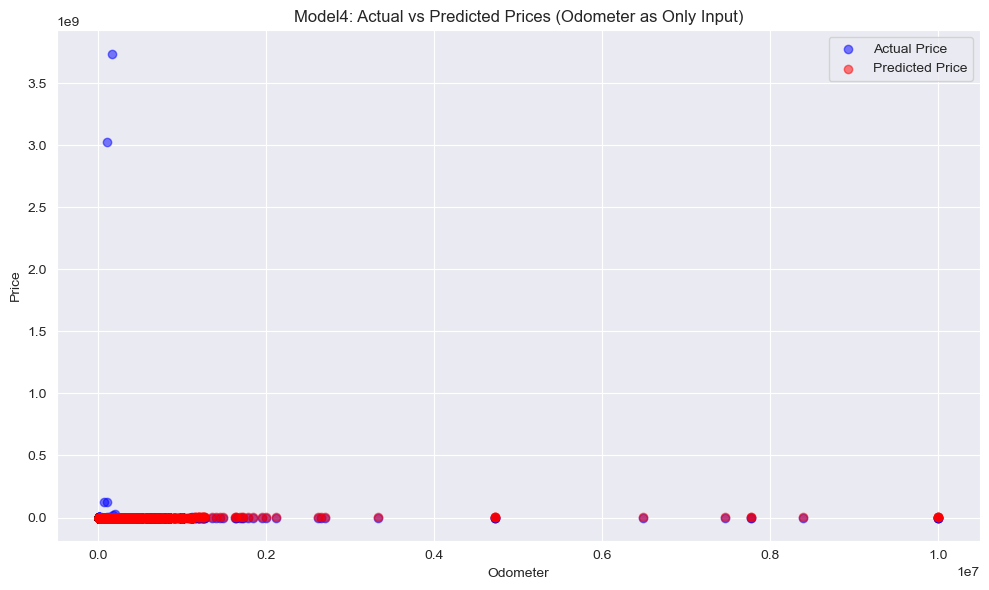

In [2143]:
# --- Data Filtering ---
# Assume new_car_data_df1 is your original DataFrame.
# Filter to include only rows with odometer > 5000 and price > 5000.
filtered_df = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) & (new_car_data_df1['price'] > 4000)].copy()

# --- Feature Definition ---
# Use only 'odometer' as the predictor.
X = filtered_df[['odometer']]
y = filtered_df['price']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Model Building ---
model4 = LinearRegression()
model4.fit(X_train, y_train)

# --- Predictions ---
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)

# --- Evaluation ---
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Model4 Training R²:", train_r2)
print("Model4 Training RMSE:", train_rmse)
print("Model4 Testing R²:", test_r2)
print("Model4 Testing RMSE:", test_rmse)

# --- Visualization ---
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual Price')
plt.scatter(X_test, y_test_pred, color='red', alpha=0.5, label='Predicted Price')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.title('Model4: Actual vs Predicted Prices (Odometer as Only Input)')
plt.legend()
plt.grid(True)
plt.show()

model5:Odometer and Price greater than 4000 with Odometer, Year, fuel_diesel, drive_4wd as the only inputs


Model5 Training R²: 5.845884798116874e-05
Model5 Training RMSE: 11038413.744679794
Model5 Testing R²: 2.1660790074928826e-05
Model5 Testing RMSE: 15348227.214016883


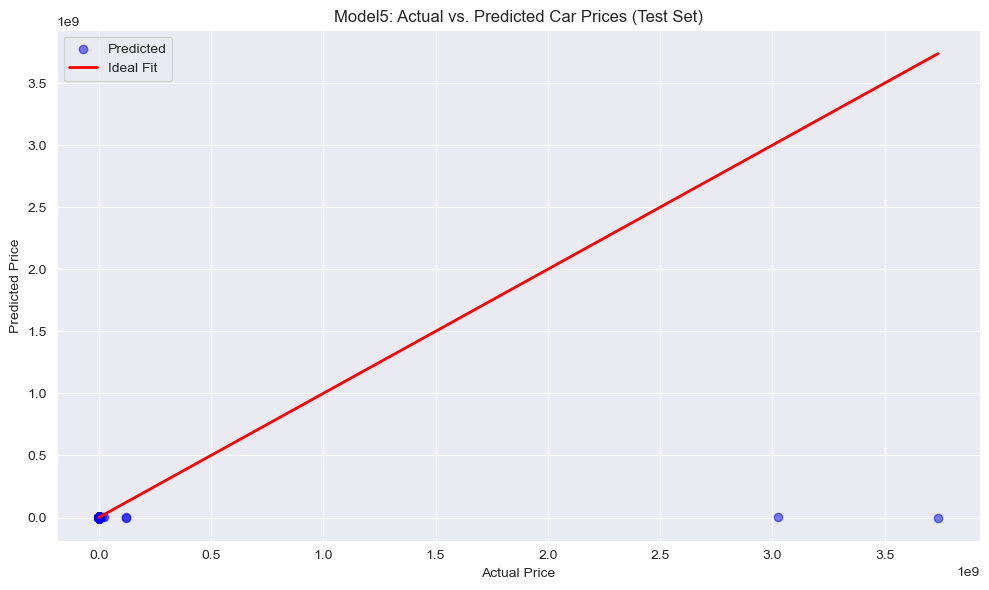

In [2144]:
# 1. Filter the dataset for rows with odometer > 4000 and price > 4000.
filtered_df = new_car_data_df1[
    (new_car_data_df1['odometer'] > 4000) & (new_car_data_df1['price'] > 4000)
].copy()

# 2. Define the feature set and target variable.
# Using: odometer, year, fuel_diesel, drive_4wd
features = ['odometer', 'year', 'fuel_diesel', 'drive_4wd']
X = filtered_df[features]
y = filtered_df['price']

# 3. Split the data into training and testing sets (70% train, 30% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Build and train the linear regression model.
model5 = LinearRegression()
model5.fit(X_train, y_train)

# 5. Make predictions on the training and test sets.
y_train_pred = model5.predict(X_train)
y_test_pred = model5.predict(X_test)

# 6. Evaluate model performance using R² and RMSE.
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Model5 Training R²:", train_r2)
print("Model5 Training RMSE:", train_rmse)
print("Model5 Testing R²:", test_r2)
print("Model5 Testing RMSE:", test_rmse)

# 7. Visualization: Plot Actual vs. Predicted Prices (Test Set).
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.5, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Ideal Fit')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Model5: Actual vs. Predicted Car Prices (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

Model6:Odometer and Price greater than 4000 and  Year > 2000 with Odometer, Year, fuel_diesel,  drive_4wd

Model6 Training R²: 1.8469934626619278e-05
Model6 Training RMSE: 8443560.56544504
Model6 Testing R²: -1.7802915965249788
Model6 Testing RMSE: 60483.32724354929


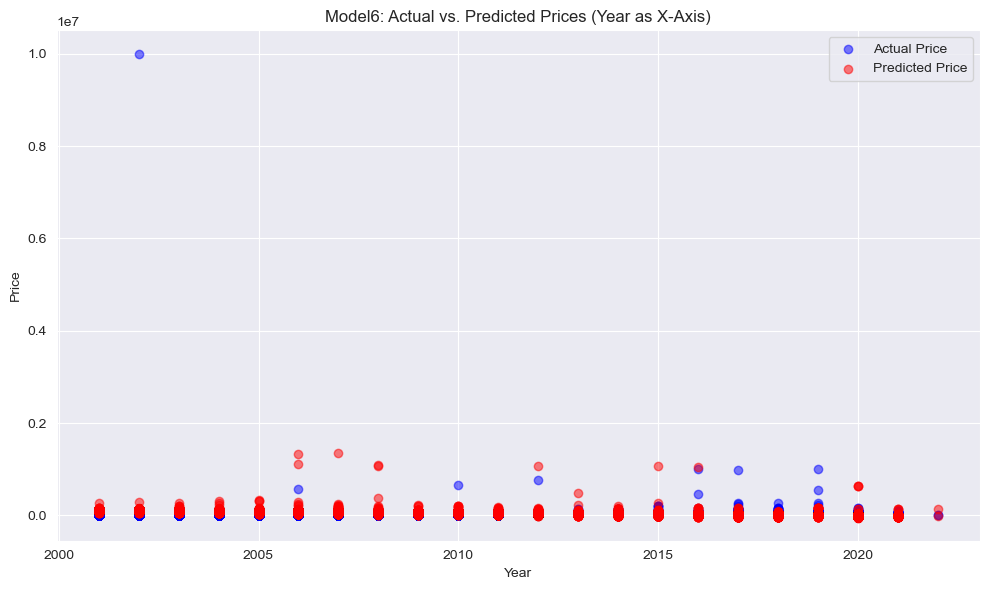

In [2145]:
# 1. Filter the dataset:
#    Only include rows with odometer > 4000, price > 4000, and year > 1990.
filtered_df = new_car_data_df1[
    (new_car_data_df1['odometer'] > 4000) &
    (new_car_data_df1['price'] > 4000) &
    (new_car_data_df1['year'] > 2000)
].copy()

# 2. Define the feature set and target variable.
# Use: odometer, year, fuel_diesel, drive_4wd
features = ['odometer', 'year', 'fuel_diesel', 'drive_4wd']
X = filtered_df[features]
y = filtered_df['price']

# 3. Split the data into training and testing sets (70% train, 30% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Build and train the linear regression model.
model6 = LinearRegression()
model6.fit(X_train, y_train)

# 5. Make predictions on the training and testing sets.
y_train_pred = model6.predict(X_train)
y_test_pred = model6.predict(X_test)

# 6. Evaluate model performance using R² and RMSE.
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Model6 Training R²:", train_r2)
print("Model6 Training RMSE:", train_rmse)
print("Model6 Testing R²:", test_r2)
print("Model6 Testing RMSE:", test_rmse)

# 7. Optional Visualization: Plot Actual vs. Predicted Prices for the Test Set.
plt.figure(figsize=(10,6))
plt.scatter(X_test['year'], y_test, color='blue', alpha=0.5, label='Actual Price')
plt.scatter(X_test['year'], y_test_pred, color='red', alpha=0.5, label='Predicted Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Model6: Actual vs. Predicted Prices (Year as X-Axis)')
plt.legend()
plt.grid(True)
plt.show()

Train MSE: 121853241808802.22
Test MSE: 235573289550137.16
Train R²: 3.771875091151955e-06
Test R²: -4.594573133065438e-07


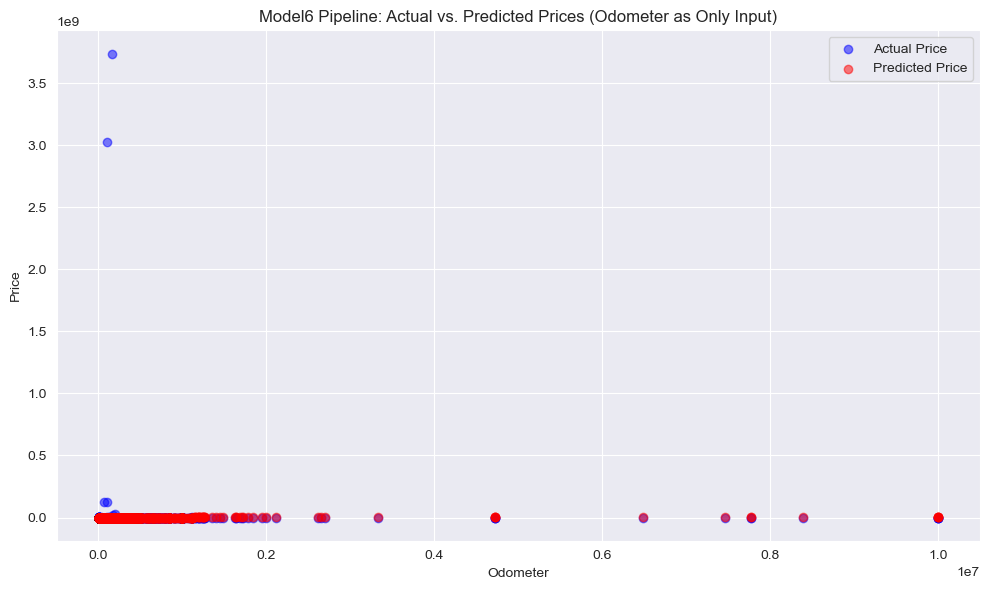

In [2146]:
# Assume new_car_data_df1 is your original DataFrame

# 1. Filter the dataset: only include rows with odometer > 4000 and price > 4000
filtered_df = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) &
                               (new_car_data_df1['price'] > 4000)].copy()

# 2. Define the feature set and target variable.
# Use only 'odometer' as the predictor.
X = filtered_df[['odometer']]
y = filtered_df['price']

# 3. Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Construct the pipeline with named steps 'scaler' and 'ridge'
scaled_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# 5. Fit the pipeline on the training data
scaled_pipe.fit(X_train, y_train)

# 6. Use the pipeline to compute predictions on the training and test sets
train_preds = scaled_pipe.predict(X_train)
test_preds = scaled_pipe.predict(X_test)

# 7. Compute the Mean Squared Error (MSE) and R² for both training and test sets
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R²:", train_r2)
print("Test R²:", test_r2)

# 8. Optional Visualization: Actual vs. Predicted Prices for the Test Set
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual Price')
plt.scatter(X_test, test_preds, color='red', alpha=0.5, label='Predicted Price')
plt.xlabel("Odometer")
plt.ylabel("Price")
plt.title("Model6 Pipeline: Actual vs. Predicted Prices (Odometer as Only Input)")
plt.legend()
plt.grid(True)
plt.show()

Computing Autocorrelation in car Data

Autocorrelation values for Price at different lags: [-2.3943967331042e-05, -2.4820373794630922e-05, -2.677828862241343e-05, -2.65323326940955e-05, -2.3479404493541465e-05, -2.5783017030969713e-05, -2.5662266738101305e-05, -2.7417498221405204e-05, -2.6028861503274526e-05, -2.7751634410614027e-05]


<Figure size 1000x600 with 0 Axes>

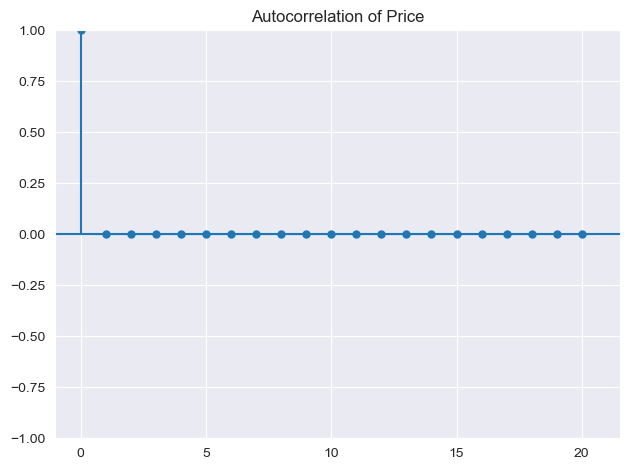

In [2147]:
# 1. Sort data by year (assuming price has a time component)
filtered_df = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) &
                               (new_car_data_df1['price'] > 4000)].copy()

filtered_df = filtered_df.sort_values(by="year")  # Ensure chronological order if needed

# 2. Compute autocorrelation for the 'price' feature
price_autocorr = [filtered_df['price'].autocorr(lag=i) for i in range(1, 21)]  # Compute for lags 1 to 20

# 3. Print the first few autocorrelations
print("Autocorrelation values for Price at different lags:", price_autocorr[:10])

# 4. Plot Autocorrelation Function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(filtered_df['price'], lags=20, alpha=0.05)  # 20 lags
plt.title("Autocorrelation of Price")
plt.show()


autocorrelation remains high across multiple lags,  indicate a trend in price over time.

Compute Autocorrelation for Price and Odometer

In [ ]:
# 1. Filter the dataset: Only include rows with odometer > 4000 and price > 4000
filtered_df = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) &
                               (new_car_data_df1['price'] > 4000)].copy()

# 2. Sort by year to ensure chronological order (if applicable)
filtered_df = filtered_df.sort_values(by="year")

# 3. Compute autocorrelation values for different lags
lags = 20  # Define number of lags

# Compute autocorrelation for 'price' and 'odometer'
price_autocorr = [filtered_df['price'].autocorr(lag=i) for i in range(1, lags+1)]
odometer_autocorr = [filtered_df['odometer'].autocorr(lag=i) for i in range(1, lags+1)]

# Print first 10 autocorrelation values
print("Autocorrelation values for Price:", price_autocorr[:10])
print("Autocorrelation values for Odometer:", odometer_autocorr[:10])

# 4. Plot the Autocorrelation Function (ACF) for Price and Odometer
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot ACF for Price
plot_acf(filtered_df['price'], lags=lags, alpha=0.05, ax=axs[0])
axs[0].set_title("Autocorrelation of Price")

# Plot ACF for Odometer
plot_acf(filtered_df['odometer'], lags=lags, alpha=0.05, ax=axs[1])
axs[1].set_title("Autocorrelation of Odometer")

plt.tight_layout()
plt.show()

Autocorrelation values for Price: [-2.3943967331042e-05, -2.4820373794630922e-05, -2.677828862241343e-05, -2.65323326940955e-05, -2.3479404493541465e-05, -2.5783017030969713e-05, -2.5662266738101305e-05, -2.7417498221405204e-05, -2.6028861503274526e-05, -2.7751634410614027e-05]
Autocorrelation values for Odometer: [0.08723006634459199, 0.08626675512086186, 0.12679959851655148, 0.08743747846306195, 0.08998255393883331, 0.09888233065325643, 0.08630622946545093, 0.08593040584838191, 0.08399946643397378, 0.08636277604818189]


Partial Autocorrelation Analysis (PACF) for Price and Odometer

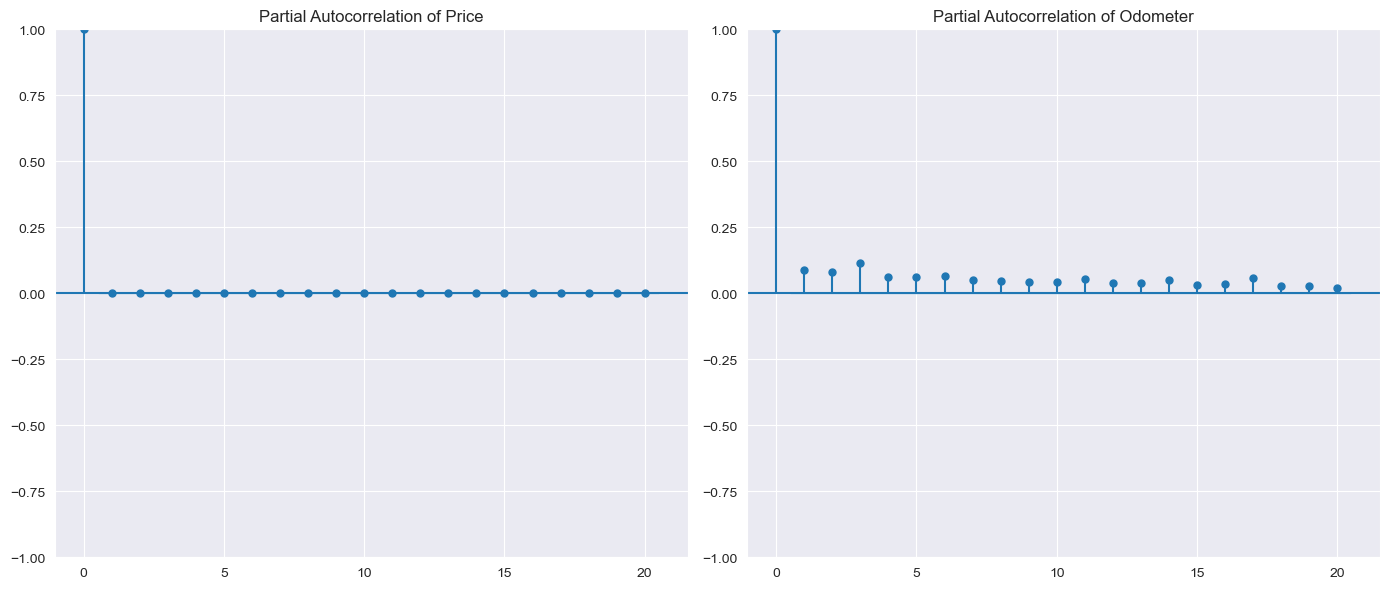

In [1992]:

# 1. Filter the dataset: Only include rows with odometer > 4000 and price > 4000
filtered_df = new_car_data_df1[(new_car_data_df1['odometer'] > 4000) &
                               (new_car_data_df1['price'] > 4000)].copy()

# 2. Sort by year to ensure chronological order (if applicable)
filtered_df = filtered_df.sort_values(by="year")

# 3. Define the number of lags to examine
lags = 20

# 4. Plot Partial Autocorrelation Function (PACF) for Price and Odometer
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# PACF for Price
plot_pacf(filtered_df['price'], lags=lags, alpha=0.05, ax=axs[0], method='yw')
axs[0].set_title("Partial Autocorrelation of Price")

# PACF for Odometer
plot_pacf(filtered_df['odometer'], lags=lags, alpha=0.05, ax=axs[1], method='yw')
axs[1].set_title("Partial Autocorrelation of Odometer")

plt.tight_layout()
plt.show()


odometer PACF shows strong autocorrelation, past mileage trends may be used to estimate future odometer readings

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Data Quality and Preparation Observations

The quality of the data provided is not the best, there is data missing, values provided like $0 for price, 0 value for Odometer are not realistic for used cars. It was challenging to use variables standardization or normalizations (i.e., mean and median) to replace unrealistic values for Odometer and Price.

This is because there are different features for the cars like Fuel, Condition, Type, Color etc so you would have to use these features to replace the missing/unrealistic values if you wanted to complete a realistic data prep/manipulation process.

As a result of this analysis, we decided to remove these records. Also removed features like ID, VIN, State, Manufacturer, model etc which we did not think had a significant impact on used car prices.

### Regression Model Observations

The business objective is to identify key features for used car prices based on the dataset provided so that Car Dealers and Sales People can use these key features to understand the cars that they need to have in their inventory to increase sales.

We ran a number of models using the full set of features after data manipulation, using a subset of features based on the correlation matrix between the features and used car prices.

Best alpha: 100
Model Performance on Log Scale:
RMSE (log scale): 0.538135687465595
R² (log scale): 0.39273522108136893

Model Performance on Original Price Scale:
RMSE: 15348687.514835637
R²: -3.831978540769221e-05


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Introduction

This machine learning application has been built using a dataset on over 400k used car sales over a century to analyze the factors that make a car more or less expensive so that your organization and Sales Team understand the what your consumers value in used cars.

The objective is to provide you with insights so that you can tune your inventory with the cars that consumers are looking for and ultimately increase your sales and revenue.

For this application, we used a machine learning process which starts with gathering the data, cleaning, preparing and manipulating the data, training the model then testing to get predicted values and measure accuracy. As part of the life cycle, additional data from your sales should be used on an on-going bases to “improve” the model which leads to higher prediction accuracy on the factors that your consumers are looking for in a used car.

### Findings

#### Data Processing
The first thing that was apparent from the provided data was that it was not clean, it had missing values and some of the values were not realistic for used cars, for example, odometer with zero and single digit values; price with zero and single digits values.

A Summary of the Data Preparation is as follows:
- Remove records with Zero Prices and Odometer values
- Remove records where some of the factors are not populated
- Drop a number of factors (i.e., VIN, id, region etc.) that are not significant in user car price determination
- Review and remove the other factors (i.e., state, paint color, manufacturer, transmission etc.) and check if they have an impact on car price based on the provided data
- Filtering the data based on year on manufacture = 1990 as the number of used cars before 1990 were very low

#### Data Application
With this data preparation, we used the following factors in building the Machine Learning application
- Price
- Year
- Condition
- Fuel Type
- Odometer
- Drive Train and
- Size

In building and testing the application we observed that using car records with year greater than 1990 provided the best accuracy for the provided dataset. We simply have more records for this period as shown in the diagram below:


This data provided an application with an accuracy of 47%+ when predicting used car prices using factors like odometer, year, fuel type, drive train

When we analyzed the factors contributing to the used car price in the application, we observed the following order of importance:
1. Diesel Fuel
2. Year
3. Odometer
4. Four Wheel Drive


Based on these findings for this dataset, it looks like Consumers are more interested in Diesel fuel cars, followed by Year and Odometer (which are sometimes related). For example, a newer car should have lower mileage, there are exceptions, for example, Rental Cars. Four Wheel Drive (also known as All Wheel Drive)  were the fourth/fifth feature of importance.